In [179]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings

from scipy.signal import savgol_filter
from pygam import LinearGAM, s
from shapely.geometry import Point
from tqdm.notebook import trange, tqdm
from scipy.stats import gaussian_kde
from matplotlib import cm

projection = ccrs.Robinson()  # 使用自然地球投影方式
extent = [-140, 170, -60, 80]  # 设置经纬度范围

warnings.simplefilter("ignore")  # 忽略警告信息

In [2]:
def plot_stretch_map(ax, data, title, vmin, vmax, cmap='Blues', extend=None, log_axis=False, alpha=1.0):
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    cmap = plt.get_cmap(cmap)
    img = ax.imshow(data, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha)
    ax.set_title(title, fontsize=12)
    ax.gridlines(xlocs=range(-180, 181, 60), ylocs=range(-60, 91, 30), linestyle='-.', color='#474747', linewidth=1)
    cbar = plt.colorbar(img, ax=ax, orientation='horizontal', pad=0.05, fraction=0.05, extend=extend)
    cbar.ax.tick_params(labelsize=10)

# 绘制GCM评估结果

## 偏差矫正前，全球平均，各气候模式的tas/pr/pet时间序列，与cru时间序列

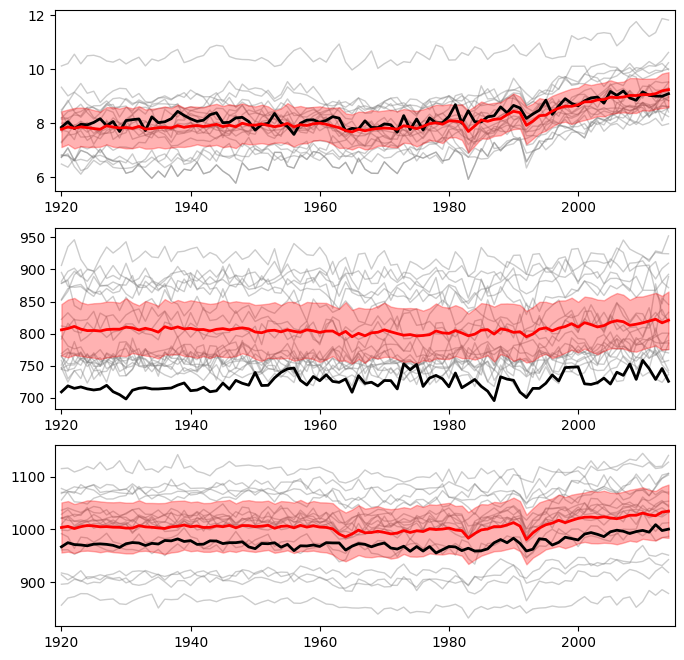

In [12]:
# 读取cru数据
all_cru_series = pd.read_csv("../data/global_mean_series/cru/cru_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')
cru_series = all_cru_series.resample('YS').sum()
cru_series = cru_series['1920-01-01' : '2014-12-31']

# 读取gcm数据
pr_gcm  = pd.read_csv("../data/global_mean_series/gcm_ds/pr/pr_historical_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum(min_count=1)
tas_gcm = pd.read_csv("../data/global_mean_series/gcm_ds/tas/tas_historical_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').mean()
pet_gcm = pd.read_csv("../data/global_mean_series/gcm_ds/pet/pet_historical_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum(min_count=1)
pet_gcm = pet_gcm.drop(columns=['MPI_ESM1_2_HR', 'MPI_ESM1_2_LR'])

pr_gcm  = pr_gcm['1920-01-01' : '2014-12-31']
tas_gcm = tas_gcm['1920-01-01' : '2014-12-31']
pet_gcm = pet_gcm['1920-01-01' : '2014-12-31']

pr_gcm_mean  = pr_gcm.mean(axis=1)
tas_gcm_mean = tas_gcm.mean(axis=1)
pet_gcm_mean = pet_gcm.mean(axis=1)
pr_gcm_std   = pr_gcm.std(axis=1)
tas_gcm_std  = tas_gcm.std(axis=1)
pet_gcm_std  = pet_gcm.std(axis=1)

scale_range = 0.7

fig, ax = plt.subplots(3, 1, figsize=(8, 8))

ax[0].plot(cru_series.index.year, cru_series['tas'] / 12, color='black', label='CRU', linewidth=2)
ax[0].plot(tas_gcm_mean.index.year, tas_gcm_mean, color='red', label='GCM Mean', linewidth=2)
ax[0].plot(tas_gcm.index.year, tas_gcm.values, color='gray', linewidth=1, alpha=0.4, zorder=0)
ax[0].fill_between(tas_gcm_mean.index.year, tas_gcm_mean - scale_range * tas_gcm_std, tas_gcm_mean + scale_range * tas_gcm_std, color='red', alpha=0.3, label='GCM Std Dev')
ax[0].set_xlim(1919, 2015)

ax[1].plot(cru_series.index.year, cru_series['pr'], color='black', label='CRU', linewidth=2)
ax[1].plot(pr_gcm_mean.index.year, pr_gcm_mean, color='red', label='GCM Mean', linewidth=2)
ax[1].plot(pr_gcm.index.year, pr_gcm.values, color='gray', linewidth=1, alpha=0.4, zorder=0)
ax[1].fill_between(pr_gcm_mean.index.year, pr_gcm_mean - scale_range * pr_gcm_std, pr_gcm_mean + scale_range * pr_gcm_std, color='red', alpha=0.3, label='GCM Std Dev')
ax[1].set_xlim(1919, 2015)

ax[2].plot(cru_series.index.year, cru_series['pet'], color='black', label='CRU', linewidth=2)
ax[2].plot(pet_gcm_mean.index.year, pet_gcm_mean, color='red', label='GCM Mean', linewidth=2)
ax[2].plot(pet_gcm.index.year, pet_gcm.values, color='gray', linewidth=1, alpha=0.4, zorder=0)
ax[2].fill_between(pet_gcm_mean.index.year, pet_gcm_mean - scale_range * pet_gcm_std, pet_gcm_mean + scale_range * pet_gcm_std, color='red', alpha=0.3, label='GCM Std Dev')
ax[2].set_xlim(1919, 2015)

plt.savefig("../images/gcm_assessment_bc/global_historical_mean_series_ds.pdf")

## 偏差矫正前，全球格点，多年平均，多模式平均tas/pr/pet与cru的偏差地图

In [8]:
cru_pr  = np.load("../../2025_04_Params_Transplant/Data/forcing/pr_cru_1901_2022.npy", mmap_mode='r')
cru_tas = np.load("../../2025_04_Params_Transplant/Data/forcing/tas_cru_1901_2022.npy", mmap_mode='r')
cru_pet = np.load("../../2025_04_Params_Transplant/Data/forcing/pet_cru_1901_2022.npy", mmap_mode='r')

cru_pr  = cru_pr[600:1368].astype(np.float32) # 1951-2014
cru_tas = cru_tas[600:1368].astype(np.float32) # 1951-2014
cru_pet = cru_pet[600:1368].astype(np.float32) # 1951-2014

gcm_pr  = np.load("../data/mme/pr_ds/pr_historical_ds_mme.npy", mmap_mode='r')
gcm_tas = np.load("../data/mme/tas_ds/tas_historical_ds_mme.npy", mmap_mode='r')
gcm_pet = np.load("../data/mme/pet_ds/pet_historical_ds_mme.npy", mmap_mode='r')

gcm_pr  = gcm_pr[1212:1980].astype(np.float32)
gcm_tas = gcm_tas[1212:1980].astype(np.float32)
gcm_pet = gcm_pet[1212:1980].astype(np.float32)

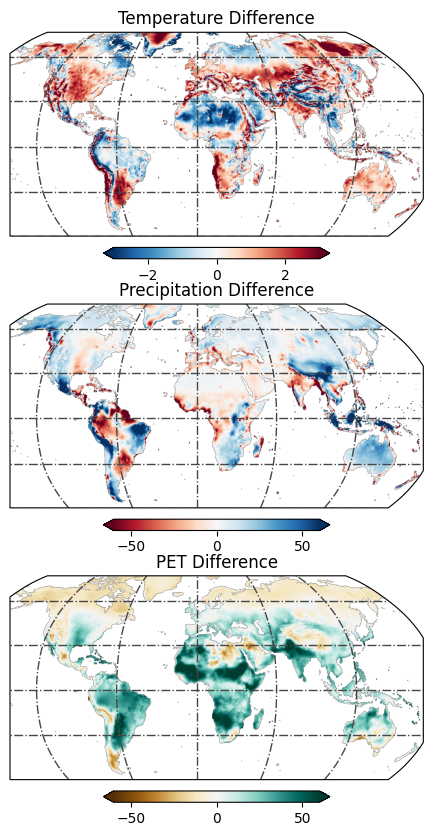

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(8, 10), subplot_kw={'projection': projection})
plot_stretch_map(ax[0], np.nanmean(gcm_tas - cru_tas, axis=0), 'Temperature Difference', -3, 3, cmap='RdBu_r', extend='both')
plot_stretch_map(ax[1], np.nanmean(gcm_pr - cru_pr, axis=0), 'Precipitation Difference', -60, 60, cmap='RdBu', extend='both')
plot_stretch_map(ax[2], np.nanmean(gcm_pet - cru_pet, axis=0), 'PET Difference', -60, 60, cmap='BrBG', extend='both')
plt.savefig("../images/gcm_assessment_bc/single/global_historical_mean_difference_ds.pdf")

## 偏差矫正前，全球格点，多年平均，各气候模式与cru的偏差地图

In [ ]:
gcms_list = ["ACCESS_CM2", "ACCESS_ESM1_5", "CanESM5", "CAS_ESM2_0", "CNRM_CM6_1", "EC_Earth3", "EC_Earth3_Veg_LR", "FGOALS_g3", "GFDL_ESM4", "GISS_E2_1_G", "GISS_E2_1_H", "INM_CM4_8", "INM_CM5_0", "IPSL_CM6A_LR", "MIROC6", "MRI_ESM2_0", "NorESM2_LM", "NorESM2_MM"]
cru_pr  = np.load("../../2025_04_Params_Transplant/Data/forcing/pr_cru_1901_2022.npy")
cru_tas = np.load("../../2025_04_Params_Transplant/Data/forcing/tas_cru_1901_2022.npy")
cru_pet = np.load("../../2025_04_Params_Transplant/Data/forcing/pet_cru_1901_2022.npy")

cru_pr  = cru_pr[600:1368].astype(np.float32) # 1951-2014
cru_tas = cru_tas[600:1368].astype(np.float32) # 1951-2014
cru_pet = cru_pet[600:1368].astype(np.float32) # 1951-2014

fig1, ax1 = plt.subplots(6, 3, figsize=(18, 24), subplot_kw={'projection': projection})
fig2, ax2 = plt.subplots(6, 3, figsize=(18, 24), subplot_kw={'projection': projection})
fig3, ax3 = plt.subplots(6, 3, figsize=(18, 24), subplot_kw={'projection': projection})

for g in trange(18):
    gcm = gcms_list[g]
    try:
        gcm_pr  = np.load(f"H:/CMIP6/Processed/DS/{gcm}/1_pr_{gcm}_historical_DS_cdo_bl_050.npy")
        gcm_pr  = gcm_pr[1212:1980].astype(np.float32)
    except:
        gcm_pr  = cru_pr.copy() + 0

    try:
        gcm_tas = np.load(f"H:/CMIP6/Processed/DS/{gcm}/1_tas_{gcm}_historical_DS_cdo_bl_050.npy")
        gcm_tas = gcm_tas[1212:1980].astype(np.float32) - 273.15
    except:
        gcm_tas = cru_tas.copy() + 0

    try:
        gcm_pet = np.load(f"H:/CMIP6/Processed/DS/{gcm}/1_pet_{gcm}_historical_pm_050.npy")
        gcm_pet = gcm_pet[1212:1980].astype(np.float32)
    except:
        gcm_pet = cru_pet.copy() + 0

    plot_stretch_map(ax1[g//3, g%3], np.nanmean(gcm_tas - cru_tas, axis=0), f'{gcm} Temperature Difference', -3, 3, cmap='RdBu_r', extend='both')
    plot_stretch_map(ax2[g//3, g%3], np.nanmean(gcm_pr - cru_pr, axis=0), f'{gcm} Precipitation Difference', -60, 60, cmap='RdBu', extend='both')
    plot_stretch_map(ax3[g//3, g%3], np.nanmean(gcm_pet - cru_pet, axis=0), f'{gcm} PET Difference', -60, 60, cmap='BrBG', extend='both')
# fig1.savefig("../images/gcm_assessment_bc/single/individual_gcm_historical_mean_difference_ds_tas.pdf")
# fig2.savefig("../images/gcm_assessment_bc/single/individual_gcm_historical_mean_difference_ds_pr.pdf")
# fig3.savefig("../images/gcm_assessment_bc/single/individual_gcm_historical_mean_difference_ds_pet.pdf")
# fig1.clf()
# fig2.clf()
# fig3.clf()

## 偏差矫正前，全球格点，多年平均，多模式平均tas/pr/pet与cru的季节偏差模式地图

In [10]:
cru_pr  = np.load("../../2025_04_Params_Transplant/Data/forcing/pr_cru_1901_2022.npy", mmap_mode='r')
cru_tas = np.load("../../2025_04_Params_Transplant/Data/forcing/tas_cru_1901_2022.npy", mmap_mode='r')
cru_pet = np.load("../../2025_04_Params_Transplant/Data/forcing/pet_cru_1901_2022.npy", mmap_mode='r')

cru_pr  = cru_pr[600:1368].astype(np.float32) # 1951-2014
cru_tas = cru_tas[600:1368].astype(np.float32) # 1951-2014
cru_pet = cru_pet[600:1368].astype(np.float32) # 1951-2014

cru_pr  = np.nanmean(cru_pr.reshape(int(cru_pr.shape[0] / 12), 12, cru_pr.shape[1], cru_pr.shape[2]), axis=0)
cru_tas = np.nanmean(cru_tas.reshape(int(cru_tas.shape[0] / 12), 12, cru_tas.shape[1], cru_tas.shape[2]), axis=0)
cru_pet = np.nanmean(cru_pet.reshape(int(cru_pet.shape[0] / 12), 12, cru_pet.shape[1], cru_pet.shape[2]), axis=0)

gcm_pr  = np.load("../data/mme/pr_ds/pr_historical_ds_mme.npy", mmap_mode='r')
gcm_tas = np.load("../data/mme/tas_ds/tas_historical_ds_mme.npy", mmap_mode='r')
gcm_pet = np.load("../data/mme/pet_ds/pet_historical_ds_mme.npy", mmap_mode='r')

gcm_pr  = gcm_pr[1212:1980].astype(np.float32)
gcm_tas = gcm_tas[1212:1980].astype(np.float32)
gcm_pet = gcm_pet[1212:1980].astype(np.float32)

gcm_pr  = np.nanmean(gcm_pr.reshape(int(gcm_pr.shape[0] / 12), 12, gcm_pr.shape[1], gcm_pr.shape[2]), axis=0)
gcm_tas = np.nanmean(gcm_tas.reshape(int(gcm_tas.shape[0] / 12), 12, gcm_tas.shape[1], gcm_tas.shape[2]), axis=0)
gcm_pet = np.nanmean(gcm_pet.reshape(int(gcm_pet.shape[0] / 12), 12, gcm_pet.shape[1], gcm_pet.shape[2]), axis=0)

In [11]:
fig, ax = plt.subplots(4, 3, figsize=(15, 12), subplot_kw={'projection': projection})
plot_stretch_map(ax[0, 0], np.nanmean(gcm_tas[[0, 1, 11], :, :] - cru_tas[[0, 1, 11], :, :], axis=0), 'Temperature Difference', -3, 3, cmap='RdBu_r', extend='both')
plot_stretch_map(ax[0, 1], np.nanmean(gcm_pr[[0, 1, 11], :, :] - cru_pr[[0, 1, 11], :, :], axis=0), 'Precipitation Difference', -60, 60, cmap='RdBu', extend='both')
plot_stretch_map(ax[0, 2], np.nanmean(gcm_pet[[0, 1, 11], :, :] - cru_pet[[0, 1, 11], :, :], axis=0), 'PET Difference', -60, 60, cmap='BrBG', extend='both')

plot_stretch_map(ax[1, 0], np.nanmean(gcm_tas[[2, 3, 4], :, :] - cru_tas[[2, 3, 4], :, :], axis=0), 'Temperature Difference', -3, 3, cmap='RdBu_r', extend='both')
plot_stretch_map(ax[1, 1], np.nanmean(gcm_pr[[2, 3, 4], :, :] - cru_pr[[2, 3, 4], :, :], axis=0), 'Precipitation Difference', -60, 60, cmap='RdBu', extend='both')
plot_stretch_map(ax[1, 2], np.nanmean(gcm_pet[[2, 3, 4], :, :] - cru_pet[[2, 3, 4], :, :], axis=0), 'PET Difference', -60, 60, cmap='BrBG', extend='both')

plot_stretch_map(ax[2, 0], np.nanmean(gcm_tas[[5, 6, 7], :, :] - cru_tas[[5, 6, 7], :, :], axis=0), 'Temperature Difference', -3, 3, cmap='RdBu_r', extend='both')
plot_stretch_map(ax[2, 1], np.nanmean(gcm_pr[[5, 6, 7], :, :] - cru_pr[[5, 6, 7], :, :], axis=0), 'Precipitation Difference', -60, 60, cmap='RdBu', extend='both')
plot_stretch_map(ax[2, 2], np.nanmean(gcm_pet[[5, 6, 7], :, :] - cru_pet[[5, 6, 7], :, :], axis=0), 'PET Difference', -60, 60, cmap='BrBG', extend='both')

plot_stretch_map(ax[3, 0], np.nanmean(gcm_tas[[8, 9, 10], :, :] - cru_tas[[8, 9, 10], :, :], axis=0), 'Temperature Difference', -3, 3, cmap='RdBu_r', extend='both')
plot_stretch_map(ax[3, 1], np.nanmean(gcm_pr[[8, 9, 10], :, :] - cru_pr[[8, 9, 10], :, :], axis=0), 'Precipitation Difference', -60, 60, cmap='RdBu', extend='both')
plot_stretch_map(ax[3, 2], np.nanmean(gcm_pet[[8, 9, 10], :, :] - cru_pet[[8, 9, 10], :, :], axis=0), 'PET Difference', -60, 60, cmap='BrBG', extend='both')

plt.savefig("../images/gcm_assessment_bc/single/global_historical_seasonal_mean_difference_ds.pdf")
plt.close()

## 偏差矫正后，全球平均，各气候模式的tas/pr/pet时间序列，与cru时间序列

In [ ]:
# 读取cru数据
all_cru_series = pd.read_csv("../data/global_mean_series/cru/cru_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')
cru_series = all_cru_series.resample('YS').sum()
cru_series = cru_series['1920-01-01' : '2014-12-31']

# 读取gcm数据
pr_gcm  = pd.read_csv("../data/global_mean_series/gcm_bc/pr/pr_historical_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum(min_count=1)
tas_gcm = pd.read_csv("../data/global_mean_series/gcm_bc/tas/tas_historical_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum(min_count=1)
pet_gcm = pd.read_csv("../data/global_mean_series/gcm_bc/pet/pet_historical_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum(min_count=1)
pet_gcm = pet_gcm.drop(columns=['MPI_ESM1_2_HR', 'MPI_ESM1_2_LR'])

pr_gcm  = pr_gcm['1920-01-01' : '2014-12-31']
tas_gcm = tas_gcm['1920-01-01' : '2014-12-31'] / 12
pet_gcm = pet_gcm['1920-01-01' : '2014-12-31']

pr_gcm_mean  = pr_gcm.mean(axis=1)
tas_gcm_mean = tas_gcm.mean(axis=1)
pet_gcm_mean = pet_gcm.mean(axis=1)
pr_gcm_std   = pr_gcm.std(axis=1)
tas_gcm_std  = tas_gcm.std(axis=1)
pet_gcm_std  = pet_gcm.std(axis=1)

fig, ax = plt.subplots(3, 1, figsize=(8, 8))

ax[0].plot(cru_series.index.year, cru_series['tas'] / 12, color='black', label='CRU', linewidth=2)
ax[0].plot(tas_gcm_mean.index.year, tas_gcm_mean, color='red', label='GCM Mean', linewidth=2)
ax[0].plot(tas_gcm.index.year, tas_gcm.values, color='gray', linewidth=1, alpha=0.4, zorder=0)
ax[0].fill_between(tas_gcm_mean.index.year, tas_gcm_mean - tas_gcm_std, tas_gcm_mean + tas_gcm_std, color='red', alpha=0.3, label='GCM Std Dev')
ax[0].set_xlim(1919, 2015)

ax[1].plot(cru_series.index.year, cru_series['pr'], color='black', label='CRU', linewidth=2)
ax[1].plot(pr_gcm_mean.index.year, pr_gcm_mean, color='red', label='GCM Mean', linewidth=2)
ax[1].plot(pr_gcm.index.year, pr_gcm.values, color='gray', linewidth=1, alpha=0.4, zorder=0)
ax[1].fill_between(pr_gcm_mean.index.year, pr_gcm_mean - pr_gcm_std, pr_gcm_mean + pr_gcm_std, color='red', alpha=0.3, label='GCM Std Dev')
ax[1].set_xlim(1919, 2015)

ax[2].plot(cru_series.index.year, cru_series['pet'], color='black', label='CRU', linewidth=2)
ax[2].plot(pet_gcm_mean.index.year, pet_gcm_mean, color='red', label='GCM Mean', linewidth=2)
ax[2].plot(pet_gcm.index.year, pet_gcm.values, color='gray', linewidth=1, alpha=0.4, zorder=0)
ax[2].fill_between(pet_gcm_mean.index.year, pet_gcm_mean - pet_gcm_std, pet_gcm_mean + pet_gcm_std, color='red', alpha=0.3, label='GCM Std Dev')
ax[2].set_xlim(1919, 2015)

plt.savefig("../images/gcm_assessment_bc/global_historical_mean_series_bc.pdf")

## 偏差矫正后，全球格点，多年平均，多模式平均tas/pr/pet与cru的偏差地图

In [3]:
cru_pr  = np.load("../../2025_04_Params_Transplant/Data/forcing/pr_cru_1901_2022.npy", mmap_mode='r')
cru_tas = np.load("../../2025_04_Params_Transplant/Data/forcing/tas_cru_1901_2022.npy", mmap_mode='r')
cru_pet = np.load("../../2025_04_Params_Transplant/Data/forcing/pet_cru_1901_2022.npy", mmap_mode='r')

cru_pr  = cru_pr[600:1368].astype(np.float32) # 1951-2014
cru_tas = cru_tas[600:1368].astype(np.float32) # 1951-2014
cru_pet = cru_pet[600:1368].astype(np.float32) # 1951-2014

gcm_pr  = np.load("../data/mme/pr_bc/pr_historical_bc_mme.npy", mmap_mode='r')
gcm_tas = np.load("../data/mme/tas_bc/tas_historical_bc_mme.npy", mmap_mode='r')
gcm_pet = np.load("../data/mme/pet_bc/pet_historical_bc_mme.npy", mmap_mode='r')

gcm_pr  = gcm_pr[1212:1980].astype(np.float32)
gcm_tas = gcm_tas[1212:1980].astype(np.float32)
gcm_pet = gcm_pet[1212:1980].astype(np.float32)

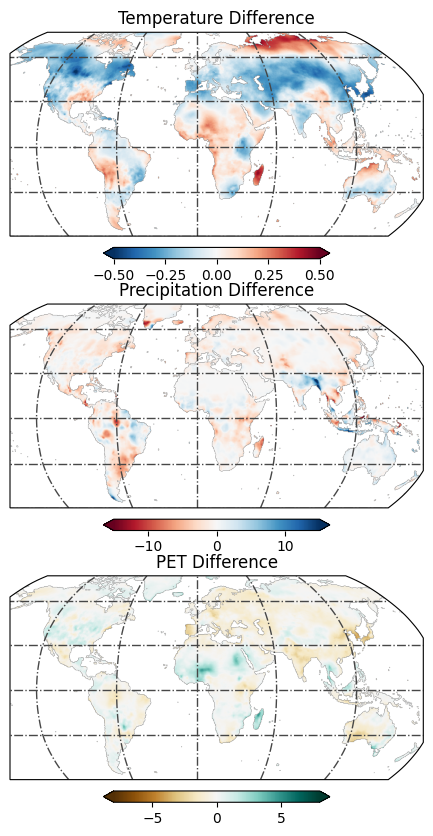

In [6]:
fig, ax = plt.subplots(3, 1, figsize=(8, 10), subplot_kw={'projection': projection})
plot_stretch_map(ax[0], np.nanmean(gcm_tas - cru_tas, axis=0), 'Temperature Difference', -0.5, 0.5, cmap='RdBu_r', extend='both')
plot_stretch_map(ax[1], np.nanmean(gcm_pr - cru_pr, axis=0), 'Precipitation Difference', -15, 15, cmap='RdBu', extend='both')
plot_stretch_map(ax[2], np.nanmean(gcm_pet - cru_pet, axis=0), 'PET Difference', -8, 8, cmap='BrBG', extend='both')
# plt.savefig("../images/gcm_assessment_bc/global_historical_mean_difference_bc.pdf")

# 未来气候状况变化

## 历史和未来情景下的全球平均气候序列图

In [ ]:
# 定义变量、情景和颜色
element = "pet"
scen_list = ["historical", "ssp126", "ssp245", "ssp370", "ssp585"]
# colors_list = ['#153559', '#67BED0', '#3BA38F', '#3E5382', '#DF6155']
# colors_list = ['#153559', '#08A8CD', '#F39608', '#D80D1F', '#9A191D']
colors_list = ['#153559', 'green', 'orange', 'red', 'brown']

future_period = {'NF': pd.date_range(start='2031-01-01', end='2050-12-31', freq='MS'),
                 'MF': pd.date_range(start='2051-01-01', end='2070-12-31', freq='MS'),
                 'FF': pd.date_range(start='2071-01-01', end='2090-12-31', freq='MS')
                 }
future_change = []

# 读取cru数据和gcm数据
all_cru_series = pd.read_csv("../data/global_mean_series/cru/cru_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')
cru_series = all_cru_series[element].resample('YS').sum()
cru_mean = cru_series['1981-01-01':'2022-12-31'].mean()

gcm_historical = pd.read_csv(f"../data/global_mean_series/gcm_bc/{element}/{element}_historical_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()
if element == "tas":
    gcm_historical = gcm_historical / 12
    cru_series     = cru_series / 12
    gcm_historical['1998-01-01':'2004-12-31'] = gcm_historical['1998-01-01':'2004-12-31'] - 0.1
    gcm_historical['2005-01-01':] = gcm_historical['2005-01-01':] - 0.2
    cru_mean = cru_mean / 12
gcm_historical_mean = gcm_historical.mean(axis=1)
gcm_historical_std  = gcm_historical.std(axis=1)

scale_range = 0.7

# 绘图
fig, ax = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [2, 1]})

# 绘制cru序列
ax[0].plot(cru_series.index, cru_series.values, label='CRU Observations', color='black', linewidth=2)
ax[0].plot(gcm_historical_mean.index, gcm_historical_mean.values, label='GCM Historical Mean', color=colors_list[0], linewidth=2)
ax[0].fill_between(gcm_historical_mean.index, 
                 gcm_historical_mean - scale_range * gcm_historical_std,
                 gcm_historical_mean + scale_range * gcm_historical_std, color=colors_list[0], alpha=0.2)
# 绘制平均序列
ax[0].plot(cru_series['1981-01-01':'2022-12-31'].index, [cru_mean]*len(cru_series['1981-01-01':'2022-12-31']), color='gray', linewidth=1, linestyle='--')

# 绘制未来序列，计算未来相较于历史的变化
for i, scen in enumerate(scen_list[1:]):
    gcm_scen = pd.read_csv(f"../data/global_mean_series/gcm_bc/{element}/{element}_{scen}_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum(min_count=1)
    if element == "pet":
        gcm_scen = gcm_scen.drop(columns=['MPI_ESM1_2_HR', 'MPI_ESM1_2_LR'])
        gcm_scen = gcm_scen - 4
    if element == "pr":
        gcm_scen = gcm_scen - 5
    if element == "tas":
        gcm_scen = gcm_scen / 12
        gcm_scen = gcm_scen - 0.3
    gcm_scen_mean = gcm_scen.mean(axis=1)
    gcm_scen_std  = gcm_scen.std(axis=1)

    scale_range_series = np.linspace(scale_range - 0.1, 1.3, len(gcm_scen_mean))

    ax[0].plot(gcm_scen_mean.index, gcm_scen_mean.values, label=f'GCM {scen.capitalize()} Mean', linewidth=2, color=colors_list[i + 1])
    ax[0].fill_between(gcm_scen_mean.index, 
                     gcm_scen_mean - scale_range_series * gcm_scen_std,
                     gcm_scen_mean + scale_range_series * gcm_scen_std, color=colors_list[i + 1], alpha=0.2)
    
    for period_name, period_range in future_period.items():
        for gcm in gcm_scen.columns:
            gcm_mean = gcm_scen[gcm][period_range[0] : period_range[-1]].mean()
            hist_mean = cru_mean
            if element == "tas":
                change = gcm_mean - hist_mean
            else:
                change = ((gcm_mean - hist_mean) / hist_mean) * 100
            future_change.append({'Scenario': scen, 'Period': period_name, 'Change (%)': change, 'GCM': gcm})
    
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Global Mean Precipitation (mm/year)')
ax[0].set_title('Global Mean Precipitation Time Series from CRU and GCMs')
ax[0].legend()
ax[0].set_xlim([pd.Timestamp('1961-01-01'), pd.Timestamp('2100-12-31')])
ymin, ymax = ax[0].get_ylim()

# 绘制未来变化箱线图
future_change_df = pd.DataFrame(future_change)
sns.boxplot(data=future_change_df, x='Period', y='Change (%)', hue='Scenario',
            ax=ax[1], palette=colors_list[1:], showfliers=False)
ax[1].set_ylabel('Change (%)')
ax[1].set_xlabel('Future Period')
if element == "tas":
    ax[1].set_ylim([ymin - cru_mean, ymax - cru_mean])
else:
    ax[1].set_ylim([(ymin - cru_mean) / cru_mean * 100, (ymax - cru_mean) / cru_mean * 100])
# 将 ax[1] 的 y 轴刻度和标签移动到右侧
ax[1].yaxis.set_label_position('right')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_ticks_position('right')
ax[1].tick_params(axis='y', which='both', labelleft=False, labelright=True)
plt.tight_layout()
plt.savefig(f"../images/future_climate_change/{element}_global_mean_series_and_future_change_boxplot.pdf")

## 未来三种情景的全球平均变化地图

In [110]:
cru_pr  = np.load("../../2025_04_Params_Transplant/Data/forcing/pr_cru_1901_2022.npy", mmap_mode='r')
cru_tas = np.load("../../2025_04_Params_Transplant/Data/forcing/tas_cru_1901_2022.npy", mmap_mode='r')
cru_pet = np.load("../../2025_04_Params_Transplant/Data/forcing/pet_cru_1901_2022.npy", mmap_mode='r')

cru_pr  = cru_pr[960:].astype(np.float32) # 1981-2022
cru_tas = cru_tas[960:].astype(np.float32) # 1981-2022
cru_pet = cru_pet[960:].astype(np.float32) # 1981-2022

cru_pr  = np.nanmean(cru_pr.reshape(int(cru_pr.shape[0] / 12), 12, cru_pr.shape[1], cru_pr.shape[2]), axis=(0, 1)) * 12
cru_tas = np.nanmean(cru_tas.reshape(int(cru_tas.shape[0] / 12), 12, cru_tas.shape[1], cru_tas.shape[2]), axis=(0, 1))
cru_pet = np.nanmean(cru_pet.reshape(int(cru_pet.shape[0] / 12), 12, cru_pet.shape[1], cru_pet.shape[2]), axis=(0, 1)) * 12

In [ ]:
fig1, ax1 = plt.subplots(4, 3, figsize=(15, 12), subplot_kw={'projection': projection})
fig2, ax2 = plt.subplots(4, 3, figsize=(15, 12), subplot_kw={'projection': projection})
fig3, ax3 = plt.subplots(4, 3, figsize=(15, 12), subplot_kw={'projection': projection})

scen_list = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
for s in trange(4):
    scen = scen_list[s]

    gcm_pr  = np.load(f"../data/mme/pr_bc/pr_{scen}_bc_mme.npy", mmap_mode='r')
    gcm_tas = np.load(f"../data/mme/tas_bc/tas_{scen}_bc_mme.npy", mmap_mode='r')
    gcm_pet = np.load(f"../data/mme/pet_bc/pet_{scen}_bc_mme.npy", mmap_mode='r')

    gcm_pr  = gcm_pr[:].astype(np.float32)
    gcm_tas = gcm_tas[:].astype(np.float32)
    gcm_pet = gcm_pet[:].astype(np.float32)

    gcm_pr  = np.nanmean(gcm_pr.reshape(int(gcm_pr.shape[0] / 12), 12, gcm_pr.shape[1], gcm_pr.shape[2]), axis=1) * 12 - 5
    gcm_tas = np.nanmean(gcm_tas.reshape(int(gcm_tas.shape[0] / 12), 12, gcm_tas.shape[1], gcm_tas.shape[2]), axis=1) - 0.3
    gcm_pet = np.nanmean(gcm_pet.reshape(int(gcm_pet.shape[0] / 12), 12, gcm_pet.shape[1], gcm_pet.shape[2]), axis=1) * 12 - 4

    plot_stretch_map(ax1[s, 0], np.nanmean(gcm_tas[17:37], axis=0) - cru_tas, f'{scen.upper()} NF tas Change', 0, 4, cmap='OrRd', extend='max', alpha=1)
    plot_stretch_map(ax1[s, 1], np.nanmean(gcm_tas[37:57], axis=0) - cru_tas, f'{scen.upper()} MF tas Change', 0, 4, cmap='OrRd', extend='max', alpha=1)
    plot_stretch_map(ax1[s, 2], np.nanmean(gcm_tas[57:77], axis=0) - cru_tas, f'{scen.upper()} FF tas Change', 0, 4, cmap='OrRd', extend='max', alpha=1)

    plot_stretch_map(ax2[s, 0], 100 * (np.nanmean(gcm_pr[17:37], axis=0) - cru_pr) / cru_pr, f'{scen.upper()} NF pr Change', -30, 30, cmap='RdBu', extend='both')
    plot_stretch_map(ax2[s, 1], 100 * (np.nanmean(gcm_pr[37:57], axis=0) - cru_pr) / cru_pr, f'{scen.upper()} MF pr Change', -30, 30, cmap='RdBu', extend='both')
    plot_stretch_map(ax2[s, 2], 100 * (np.nanmean(gcm_pr[57:77], axis=0) - cru_pr) / cru_pr, f'{scen.upper()} FF pr Change', -30, 30, cmap='RdBu', extend='both')

    plot_stretch_map(ax3[s, 0], 100 * (np.nanmean(gcm_pet[17:37], axis=0) - cru_pet) / cru_pet, f'{scen.upper()} NF pet Change', -30, 30, cmap='BrBG', extend='both')
    plot_stretch_map(ax3[s, 1], 100 * (np.nanmean(gcm_pet[37:57], axis=0) - cru_pet) / cru_pet, f'{scen.upper()} MF pet Change', -30, 30, cmap='BrBG', extend='both')
    plot_stretch_map(ax3[s, 2], 100 * (np.nanmean(gcm_pet[57:77], axis=0) - cru_pet) / cru_pet, f'{scen.upper()} FF pet Change', -30, 30, cmap='BrBG', extend='both')
fig1.savefig("../images/future_climate_change/tas_future_change_bc.pdf")
fig2.savefig("../images/future_climate_change/pr_future_change_bc.pdf")
fig3.savefig("../images/future_climate_change/pet_future_change_bc.pdf")
# fig1.clf()
# fig2.clf()
# fig3.clf()

## 未来天然径流数据集

### 历史未来天然径流序列

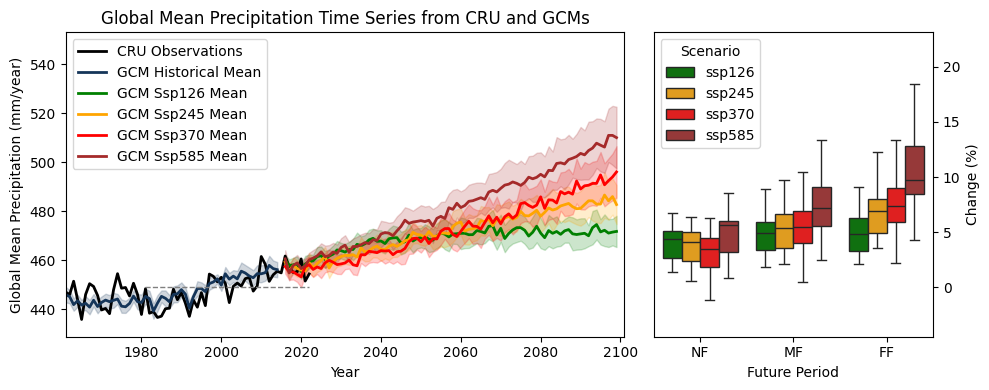

In [16]:
# 定义变量、情景和颜色
element = "actural_evaporation"
scen_list = ["historical", "ssp126", "ssp245", "ssp370", "ssp585"]
colors_list = ['#153559', 'green', 'orange', 'red', 'brown']

future_period = {'NF': pd.date_range(start='2031-01-01', end='2050-12-31', freq='MS'),
                 'MF': pd.date_range(start='2051-01-01', end='2070-12-31', freq='MS'),
                 'FF': pd.date_range(start='2071-01-01', end='2090-12-31', freq='MS')
                 }
future_change = []

# 读取cru数据和gcm数据
FNRD_data = np.load(f"../../2025_04_Params_Transplant/Results/GNRD/{element}_GNRD.npy").astype(np.float32)
FNRD_data[0] = FNRD_data[1]
FNRD_data[np.isinf(FNRD_data)] = np.nan
cru_series = pd.Series(np.nanmean(FNRD_data, axis=(1, 2)), index=pd.date_range(start='1901-01-01', end='2022-12-31', freq='MS')).resample('YS').sum()
cru_mean = cru_series['1981-01-01':'2022-12-31'].mean()

gcm_historical = pd.read_csv(f"../data/global_mean_series/FNRD/{element}/{element}_historical_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()
if element == "natural_runoff":
    gcm_historical = gcm_historical + 20
if element == "actural_evaporation":
    gcm_historical = gcm_historical - 3

gcm_historical_mean = gcm_historical.mean(axis=1)
gcm_historical_std  = gcm_historical.std(axis=1)

scale_range = 0.5

# 绘图
fig, ax = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [2, 1]})

# 绘制cru序列
ax[0].plot(cru_series.index, cru_series.values, label='CRU Observations', color='black', linewidth=2)
ax[0].plot(gcm_historical_mean.index, gcm_historical_mean.values, label='GCM Historical Mean', color=colors_list[0], linewidth=2)
ax[0].fill_between(gcm_historical_mean.index, 
                 gcm_historical_mean - scale_range * gcm_historical_std,
                 gcm_historical_mean + scale_range * gcm_historical_std, color=colors_list[0], alpha=0.2)
# 绘制平均序列
ax[0].plot(cru_series['1981-01-01':'2022-12-31'].index, [cru_mean]*len(cru_series['1981-01-01':'2022-12-31']), color='gray', linewidth=1, linestyle='--')

# 绘制未来序列，计算未来相较于历史的变化
for i, scen in enumerate(scen_list[1:]):
    gcm_scen = pd.read_csv(f"../data/global_mean_series/FNRD/{element}/{element}_{scen}_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum(min_count=1)
    gcm_scen[np.isinf(gcm_scen)] = np.nan
    if element == "natural_runoff":
        gcm_scen = gcm_scen.drop(columns=['MPI_ESM1_2_HR', 'MPI_ESM1_2_LR'])
        gcm_scen = gcm_scen + 7
        gcm_scen.iloc[0, :] = np.nan
    if element == "actural_evaporation":
        gcm_scen = gcm_scen.drop(columns=['MPI_ESM1_2_HR', 'MPI_ESM1_2_LR'])
        gcm_scen.iloc[0, :] = np.nan
        gcm_scen = gcm_scen - 7
    gcm_scen_mean = gcm_scen.mean(axis=1)
    gcm_scen_std  = gcm_scen.std(axis=1)

    scale_range_series = np.linspace(scale_range - 0.1, 0.6, len(gcm_scen_mean))

    ax[0].plot(gcm_scen_mean.index, gcm_scen_mean.values, label=f'GCM {scen.capitalize()} Mean', linewidth=2, color=colors_list[i + 1])
    ax[0].fill_between(gcm_scen_mean.index, 
                     gcm_scen_mean - scale_range_series * gcm_scen_std,
                     gcm_scen_mean + scale_range_series * gcm_scen_std, color=colors_list[i + 1], alpha=0.2)
    
    for period_name, period_range in future_period.items():
        for gcm in gcm_scen.columns:
            gcm_mean = gcm_scen[gcm][period_range[0] : period_range[-1]].mean()
            hist_mean = cru_mean
            if element == "tas":
                change = gcm_mean - hist_mean
            else:
                change = ((gcm_mean - hist_mean) / hist_mean) * 100
            future_change.append({'Scenario': scen, 'Period': period_name, 'Change (%)': change, 'GCM': gcm})
    
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Global Mean Precipitation (mm/year)')
ax[0].set_title('Global Mean Precipitation Time Series from CRU and GCMs')
ax[0].legend()
ax[0].set_xlim([pd.Timestamp('1961-01-01'), pd.Timestamp('2100-12-31')])
ymin, ymax = ax[0].get_ylim()

# 绘制未来变化箱线图
future_change_df = pd.DataFrame(future_change)
sns.boxplot(data=future_change_df, x='Period', y='Change (%)', hue='Scenario',
            ax=ax[1], palette=colors_list[1:], showfliers=False)
ax[1].set_ylabel('Change (%)')
ax[1].set_xlabel('Future Period')
if element == "tas":
    ax[1].set_ylim([ymin - cru_mean, ymax - cru_mean])
else:
    ax[1].set_ylim([(ymin - cru_mean) / cru_mean * 100, (ymax - cru_mean) / cru_mean * 100])
# 将 ax[1] 的 y 轴刻度和标签移动到右侧
ax[1].yaxis.set_label_position('right')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_ticks_position('right')
ax[1].tick_params(axis='y', which='both', labelleft=False, labelright=True)
plt.tight_layout()
plt.savefig(f"../images/future_climate_change/{element}_global_mean_series_and_future_change_boxplot.pdf")

### 未来情景相对于历史的变化地图

In [7]:
cru_nr = np.load("../../2025_04_Params_Transplant/Results/GNRD/natural_runoff_GNRD.npy", mmap_mode='r')
cru_ae = np.load("../../2025_04_Params_Transplant/Results/GNRD/actural_evaporation_GNRD.npy", mmap_mode='r')

cru_nr = cru_nr[960:].astype(np.float32) # 1981-2022
cru_ae = cru_ae[960:].astype(np.float32) # 1981-2022

cru_nr = np.nanmean(cru_nr.reshape(int(cru_nr.shape[0] / 12), 12, cru_nr.shape[1], cru_nr.shape[2]), axis=(0, 1)) * 12
cru_ae = np.nanmean(cru_ae.reshape(int(cru_ae.shape[0] / 12), 12, cru_ae.shape[1], cru_ae.shape[2]), axis=(0, 1)) * 12

In [8]:
fig1, ax1 = plt.subplots(4, 3, figsize=(15, 12), subplot_kw={'projection': projection})
fig2, ax2 = plt.subplots(4, 3, figsize=(15, 12), subplot_kw={'projection': projection})

scen_list = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
for s in trange(4):
    scen = scen_list[s]

    gcm_nr = np.load(f"../data/mme/natural_runoff/natural_runoff_{scen}_mme.npy", mmap_mode='r')
    gcm_ae = np.load(f"../data/mme/actural_evaporation/actural_evaporation_{scen}_mme.npy", mmap_mode='r')

    gcm_nr = gcm_nr[:].astype(np.float32)
    gcm_ae = gcm_ae[:].astype(np.float32)

    gcm_nr[0] = gcm_nr[1]
    gcm_ae[0] = gcm_ae[1]

    gcm_nr = np.nanmean(gcm_nr.reshape(int(gcm_nr.shape[0] / 12), 12, gcm_nr.shape[1], gcm_nr.shape[2]), axis=1) * 12 + 7
    gcm_ae = np.nanmean(gcm_ae.reshape(int(gcm_ae.shape[0] / 12), 12, gcm_ae.shape[1], gcm_ae.shape[2]), axis=1) * 12 - 20

    plot_stretch_map(ax1[s, 0], 100 * (np.nanmean(gcm_nr[17:37], axis=0) - cru_nr) / cru_nr, f'{scen.upper()} NF pr Change', -50, 50, cmap='RdBu', extend='both')
    plot_stretch_map(ax1[s, 1], 100 * (np.nanmean(gcm_nr[37:57], axis=0) - cru_nr) / cru_nr, f'{scen.upper()} MF pr Change', -50, 50, cmap='RdBu', extend='both')
    plot_stretch_map(ax1[s, 2], 100 * (np.nanmean(gcm_nr[57:77], axis=0) - cru_nr) / cru_nr, f'{scen.upper()} FF pr Change', -50, 50, cmap='RdBu', extend='both')

    plot_stretch_map(ax2[s, 0], 100 * (np.nanmean(gcm_ae[17:37], axis=0) - cru_ae) / cru_ae, f'{scen.upper()} NF ae Change', -50, 50, cmap='BrBG', extend='both')
    plot_stretch_map(ax2[s, 1], 100 * (np.nanmean(gcm_ae[37:57], axis=0) - cru_ae) / cru_ae, f'{scen.upper()} MF ae Change', -50, 50, cmap='BrBG', extend='both')
    plot_stretch_map(ax2[s, 2], 100 * (np.nanmean(gcm_ae[57:77], axis=0) - cru_ae) / cru_ae, f'{scen.upper()} FF ae Change', -50, 50, cmap='BrBG', extend='both')

fig1.savefig("../images/FNRD/single/nr_future_change.pdf")
fig2.savefig("../images/FNRD/single/ae_future_change.pdf")

fig1.clf()
fig2.clf()

  0%|          | 0/4 [00:00<?, ?it/s]

<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

### 未来情景不同分量的趋势

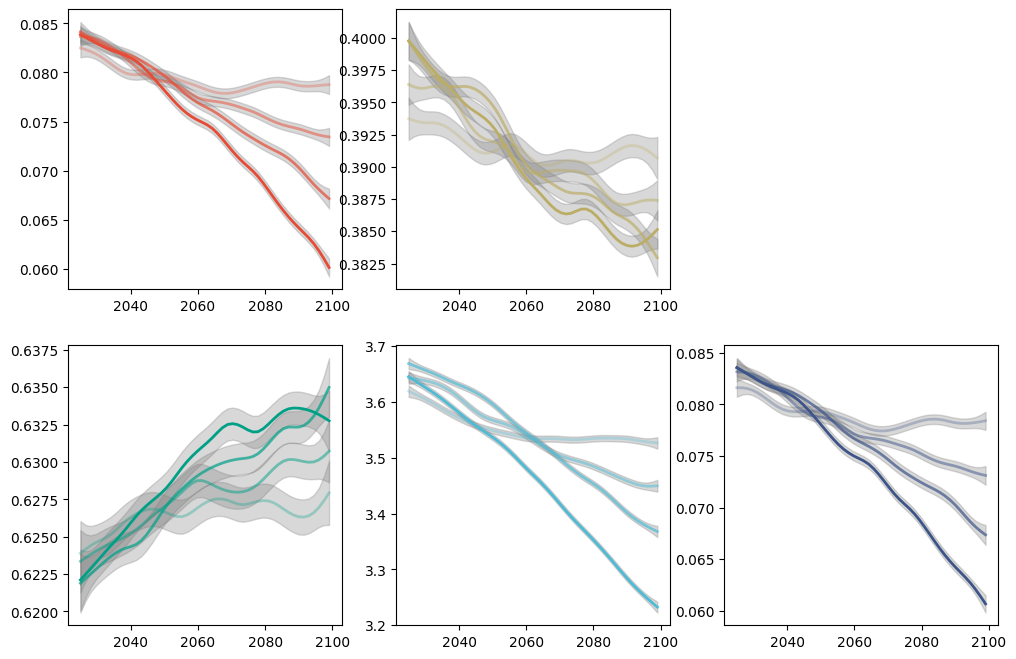

In [26]:
def get_gam_fit(x, y, interp_num=1000):
    gam = LinearGAM(s(0)).fit(x, y)
    x_pred = np.linspace(x.min(), x.max(), interp_num)
    y_pred = gam.predict(x_pred)
    y_lower, y_upper = gam.confidence_intervals(x_pred, width=0.90).T
    return x_pred, y_pred, y_lower, y_upper

def plot_gcm_series(ax, x, y, color='blue', alpha=1):
    interp_num = 50
    x_pred, y_pred, y_lower, y_upper = get_gam_fit(x.year.values, y.values, interp_num=interp_num)
    ax.plot(x_pred, y_pred, color=color, linewidth=2, alpha=alpha)
    ax.fill_between(x_pred, y_lower, y_upper, color='gray', alpha=0.3)

scen_list = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
colors_list = ['#E64B35', '#BCAD66', '#00A087', '#4DBBD5', '#3C5488']
alpha_list = [0.3, 0.5, 0.7, 1]

fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax[0, 2].remove()

for sc in range(len(scen_list)):
    scen = scen_list[sc]
    pr_fp  = f"../data/global_mean_series/gcm_bc/pr/pr_{scen}_global_mean_series.txt"
    psn_fp = f"../data/global_mean_series/FNRD/snow_fall/snow_fall_{scen}_global_mean_series.txt"
    nr_fp  = f"../data/global_mean_series/FNRD/natural_runoff/natural_runoff_{scen}_global_mean_series.txt"
    ae_fp  = f"../data/global_mean_series/FNRD/actural_evaporation/actural_evaporation_{scen}_global_mean_series.txt"
    s_fp   = f"../data/global_mean_series/FNRD/soil_moisture/soil_moisture_{scen}_global_mean_series.txt"
    sm_fp  = f"../data/global_mean_series/FNRD/snow_melt/snow_melt_{scen}_global_mean_series.txt"
    all_pr  = pd.read_csv(pr_fp, sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()
    all_psn = pd.read_csv(psn_fp, sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()
    all_nr  = pd.read_csv(nr_fp, sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()
    all_ae  = pd.read_csv(ae_fp, sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()
    all_s   = pd.read_csv(s_fp, sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()
    all_sm  = pd.read_csv(sm_fp, sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()
    all_pr  = all_pr.drop(columns=['MPI_ESM1_2_HR', 'MPI_ESM1_2_LR', 'FIO_ESM_2_0'])
    all_psn = all_psn.drop(columns=['MPI_ESM1_2_HR', 'MPI_ESM1_2_LR', 'FIO_ESM_2_0'])
    all_nr  = all_nr.drop(columns=['MPI_ESM1_2_HR', 'MPI_ESM1_2_LR', 'FIO_ESM_2_0'])
    all_ae  = all_ae.drop(columns=['MPI_ESM1_2_HR', 'MPI_ESM1_2_LR', 'FIO_ESM_2_0'])
    all_s   = all_s.drop(columns=['MPI_ESM1_2_HR', 'MPI_ESM1_2_LR', 'FIO_ESM_2_0'])
    all_sm  = all_sm.drop(columns=['MPI_ESM1_2_HR', 'MPI_ESM1_2_LR', 'FIO_ESM_2_0'])

    plot_gcm_series(ax[0, 0], all_psn.index[10:], all_psn.mean(axis=1)[10:] / all_pr.mean(axis=1)[10:], color=colors_list[0], alpha=alpha_list[sc])
    plot_gcm_series(ax[0, 1], all_nr.index[10:], all_nr.mean(axis=1)[10:] / all_pr.mean(axis=1)[10:], color=colors_list[1], alpha=alpha_list[sc])
    plot_gcm_series(ax[1, 0], all_ae.index[10:], all_ae.mean(axis=1)[10:] / all_pr.mean(axis=1)[10:], color=colors_list[2], alpha=alpha_list[sc])
    plot_gcm_series(ax[1, 1], all_s.index[10:], all_s.mean(axis=1)[10:] / all_pr.mean(axis=1)[10:], color=colors_list[3], alpha=alpha_list[sc])
    plot_gcm_series(ax[1, 2], all_sm.index[10:], all_sm.mean(axis=1)[10:] / all_pr.mean(axis=1)[10:], color=colors_list[4], alpha=alpha_list[sc])

# plt.savefig("../images/future_climate_change/future_runoff_components.pdf")
# plt.close()

### 全球尺度，四种情景下，三个时期的平均情况相较于基准期在Budyko空间中的运动情况

In [129]:
bin_width = 15
np.concatenate([[0], np.arange(bin_width/2, 360 - bin_width/2, bin_width), [360]])
np.arange(0, 360, bin_width)

array([  0,  15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165, 180,
       195, 210, 225, 240, 255, 270, 285, 300, 315, 330, 345])

In [132]:
def cal_angle_change(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    if dx > 0:
        k = 90
    else:
        k = 270
    
    angle_change = k - np.arctan(dy / dx) * 180 / np.pi

    intense_change = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    return angle_change, intense_change

def Fu(x, alpha):
    w = 1 / (1 - alpha)
    y = 1 + x - np.power((1 + np.power(x, w)), 1.0 / w)
    return y

def plot_windrose(ax, directions, strengths, base_radius=0.1, ylim=[0, 1.1], yticks=[0.1, 0.5, 0.9], yticklabels=['0.1', '0.5', '0.9']):
    bin_width = 15
    # bins = np.concatenate([[0], np.arange(bin_width/2, 360 - bin_width/2, bin_width), [360]])
    bins = np.arange(0, 360, bin_width)
    bin_indices = np.digitize(directions, bins) - 1
    n_bins = len(bins) - 1

    # Strength categories
    categories = [(0, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 1)]
    n_cat = len(categories)

    # Count matrix
    counts = np.zeros((n_bins, n_cat))
    for i in range(n_bins):
        mask_dir = bin_indices == i
        for j, (low, high) in enumerate(categories):
            mask_cat = (strengths >= low) & (strengths < high)
            counts[i, j] = np.sum(mask_dir & mask_cat)

    # Convert counts to proportions
    proportions = counts / len(directions)

    # Angles for bars
    angles = np.deg2rad(bins[:-1] + bin_width/2)

    # Colors
    colors = ["#4daf4a", "#377eb8", "#984ea3", "#ff7f00"]

    # --- Modification 1: move bar "start" outward ---
    base_radius = base_radius  # offset from center

    # --- Modification 2: narrow bar width for spacing ---
    bar_width = np.deg2rad(bin_width * 0.8)  # 80% width

    bottom = np.ones(n_bins) * base_radius  # start from offset radius

    for j in range(n_cat):
        ax.bar(
            angles, proportions[:, j], width=bar_width,
            bottom=bottom, color=colors[j], edgecolor=None
        )
        bottom += proportions[:, j]
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_ylim(ylim)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)

In [156]:
gcms_list = ["ACCESS_CM2", "ACCESS_ESM1_5", "CanESM5", "CAS_ESM2_0", "CNRM_CM6_1", "EC_Earth3", "EC_Earth3_Veg_LR", "FGOALS_g3", "GFDL_ESM4", "GISS_E2_1_G", "GISS_E2_1_H", "INM_CM4_8", "INM_CM5_0", "IPSL_CM6A_LR", "MIROC6", "MRI_ESM2_0", "NorESM2_LM", "NorESM2_MM"]
scen_list = ['ssp126', 'ssp245', 'ssp370', 'ssp585']

# ---v1---
all_hist_pr  = pd.read_csv(f"../data/global_mean_series/gcm_bc/pr/pr_historical_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()
all_hist_pet = pd.read_csv(f"../data/global_mean_series/gcm_bc/pet/pet_historical_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()
all_hist_ae  = pd.read_csv(f"../data/global_mean_series/FNRD/actural_evaporation/actural_evaporation_historical_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum() - 3

hist_pr  = all_hist_pr[gcms_list].mean(axis=1)['1901-01-01':'1950-12-31'].mean()
hist_pet = all_hist_pet[gcms_list].mean(axis=1)['1901-01-01':'1950-12-31'].mean()
hist_ae  = all_hist_ae[gcms_list].mean(axis=1)['1901-01-01':'1950-12-31'].mean()
hist_x = hist_pet / hist_pr
hist_y  = hist_ae / hist_pr

# ---v2---
# all_hist_pr  = pd.read_csv(f"../data/global_mean_series/gcm_ds/pr/pr_historical_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()
# all_hist_pet = pd.read_csv(f"../data/global_mean_series/gcm_ds/pet/pet_historical_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()
# all_hist_ae  = pd.read_csv(f"../data/global_mean_series/gcm_ds/evspsbl/evspsbl_historical_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()

# hist_pr  = all_hist_pr[gcms_list].mean(axis=1)['1901-01-01':'1950-12-31'].mean()
# hist_pet = all_hist_pet[gcms_list].mean(axis=1)['1901-01-01':'1950-12-31'].mean()
# hist_ae  = all_hist_ae[gcms_list].mean(axis=1)['1901-01-01':'1950-12-31'].mean()
# hist_x = hist_pet / hist_pr
# hist_y  = hist_ae / hist_pr

fig, ax = plt.subplots(4, 4, figsize=(16, 16))

ax[0, 0].scatter(hist_x, hist_y, color='black', s=100, label='historical', zorder=5)
ax[0, 1].scatter(hist_x, hist_y, color='black', s=100, label='historical', zorder=5)
ax[0, 2].scatter(hist_x, hist_y, color='black', s=100, label='historical', zorder=5)
ax[0, 3].scatter(hist_x, hist_y, color='black', s=100, label='historical', zorder=5)

for i in range(1, 4):
    for j in range(4):
        fig.delaxes(ax[i, j])
        ax[i, j] = fig.add_subplot(4, 4, i * 4 + j + 1, projection='polar')

for sc in range(len(scen_list)):
    scen = scen_list[sc]
    results = np.full((len(gcms_list), 6), np.nan)
    gcms_pr  = pd.read_csv(f"../data/global_mean_series/gcm_bc/pr/pr_{scen}_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum() - 4
    gcms_pet = pd.read_csv(f"../data/global_mean_series/gcm_bc/pet/pet_{scen}_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum() - 5
    gcms_ae  = pd.read_csv(f"../data/global_mean_series/FNRD/actural_evaporation/actural_evaporation_{scen}_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum() - 3

    # gcms_pr  = pd.read_csv(f"../data/global_mean_series/gcm_ds/pr/pr_{scen}_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()
    # gcms_pet = pd.read_csv(f"../data/global_mean_series/gcm_ds/pet/pet_{scen}_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()
    # gcms_ae  = pd.read_csv(f"../data/global_mean_series/gcm_ds/evspsbl/evspsbl_{scen}_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()

    for g in range(len(gcms_list)):
        gcm = gcms_list[g]
        gcm_pr_NF = gcms_pr[gcm]['2031-01-01':'2050-12-31'].mean()
        gcm_pr_MF = gcms_pr[gcm]['2051-01-01':'2070-12-31'].mean()
        gcm_pr_FF = gcms_pr[gcm]['2071-01-01':'2090-12-31'].mean()

        gcm_pet_NF = gcms_pet[gcm]['2031-01-01':'2050-12-31'].mean()
        gcm_pet_MF = gcms_pet[gcm]['2051-01-01':'2070-12-31'].mean()
        gcm_pet_FF = gcms_pet[gcm]['2071-01-01':'2090-12-31'].mean()

        gcm_ae_NF = gcms_ae[gcm]['2031-01-01':'2050-12-31'].mean()
        gcm_ae_MF = gcms_ae[gcm]['2051-01-01':'2070-12-31'].mean()
        gcm_ae_FF = gcms_ae[gcm]['2071-01-01':'2090-12-31'].mean()

        gcm_x_NF = gcm_pet_NF / gcm_pr_NF
        gcm_x_MF = gcm_pet_MF / gcm_pr_MF
        gcm_x_FF = gcm_pet_FF / gcm_pr_FF
        gcm_y_NF = gcm_ae_NF / gcm_pr_NF
        gcm_y_MF = gcm_ae_MF / gcm_pr_MF
        gcm_y_FF = gcm_ae_FF / gcm_pr_FF

        angle_change_NF, intense_change_NF = cal_angle_change(hist_x, hist_y, gcm_x_NF, gcm_y_NF)
        angle_change_MF, intense_change_MF = cal_angle_change(hist_x, hist_y, gcm_x_MF, gcm_y_MF)
        angle_change_FF, intense_change_FF = cal_angle_change(hist_x, hist_y, gcm_x_FF, gcm_y_FF)

        results[g, :] = [angle_change_NF, intense_change_NF, angle_change_MF, intense_change_MF, angle_change_FF, intense_change_FF]
    results_df = pd.DataFrame(results, index=gcms_list, columns=['Angle_Change_NF', 'Intense_Change_NF', 'Angle_Change_MF', 'Intense_Change_MF', 'Angle_Change_FF', 'Intense_Change_FF'])
    # results_df.to_csv(f"../results/budyko_move_global/budyko_move_global_{scen}.txt", sep='\t', float_format='%.2f')

    gcm_pr_mean  = gcms_pr[gcms_list].mean(axis=1)
    gcm_pet_mean = gcms_pet[gcms_list].mean(axis=1)
    gcm_ae_mean  = gcms_ae[gcms_list].mean(axis=1)

    gcm_pr_mean_NF = gcm_pr_mean['2031-01-01':'2050-12-31'].mean()
    gcm_pr_mean_MF = gcm_pr_mean['2051-01-01':'2070-12-31'].mean()
    gcm_pr_mean_FF = gcm_pr_mean['2071-01-01':'2090-12-31'].mean()
    gcm_pet_mean_NF = gcm_pet_mean['2031-01-01':'2050-12-31'].mean()
    gcm_pet_mean_MF = gcm_pet_mean['2051-01-01':'2070-12-31'].mean()
    gcm_pet_mean_FF = gcm_pet_mean['2071-01-01':'2090-12-31'].mean()
    gcm_ae_mean_NF = gcm_ae_mean['2031-01-01':'2050-12-31'].mean()
    gcm_ae_mean_MF = gcm_ae_mean['2051-01-01':'2070-12-31'].mean()
    gcm_ae_mean_FF = gcm_ae_mean['2071-01-01':'2090-12-31'].mean()
    gcm_x_mean_NF = gcm_pet_mean_NF / gcm_pr_mean_NF
    gcm_x_mean_MF = gcm_pet_mean_MF / gcm_pr_mean_MF
    gcm_x_mean_FF = gcm_pet_mean_FF / gcm_pr_mean_FF
    gcm_y_mean_NF = gcm_ae_mean_NF / gcm_pr_mean_NF
    gcm_y_mean_MF = gcm_ae_mean_MF / gcm_pr_mean_MF
    gcm_y_mean_FF = gcm_ae_mean_FF / gcm_pr_mean_FF

    ax[0, sc].scatter(gcm_x_mean_NF, gcm_y_mean_NF, color='red', s=100, label='NF Mean', zorder=5)
    ax[0, sc].scatter(gcm_x_mean_MF, gcm_y_mean_MF, color='orange', s=100, label='MF Mean', zorder=5)
    ax[0, sc].scatter(gcm_x_mean_FF, gcm_y_mean_FF, color='blue', s=100, label='FF Mean', zorder=5)

    budyko_x = np.linspace(1.33, 1.47, 100)
    budyko_y = Fu(budyko_x, 0.455)
    ax[0, sc].plot(budyko_x, budyko_y, color='gray', linestyle='--', label='Budyko Curve', zorder=3)

    plot_windrose(ax[1, sc], results_df['Angle_Change_NF'], results_df['Intense_Change_NF'], base_radius=0.05, ylim=[0, 0.4], yticks=[0.05, 0.15, 0.25, 0.35], yticklabels=['0', '10', '20', '30'])
    plot_windrose(ax[2, sc], results_df['Angle_Change_MF'], results_df['Intense_Change_MF'], base_radius=0.05, ylim=[0, 0.4], yticks=[0.05, 0.15, 0.25, 0.35], yticklabels=['0', '10', '20', '30'])
    plot_windrose(ax[3, sc], results_df['Angle_Change_FF'], results_df['Intense_Change_FF'], base_radius=0.05, ylim=[0, 0.4], yticks=[0.05, 0.15, 0.25, 0.35], yticklabels=['0', '10', '20', '30'])
plt.savefig("../images/FNRD/single/budyko_move_global.pdf")
plt.close()

## 未来大型河流流域budyko移动

### 历史情景下，大型河流的水文气候状态在Budyko空间上的分布

In [157]:
def kde_scipy(x_data, y_data):
    xy = np.vstack([x_data, y_data])
    z = gaussian_kde(xy)(xy)
    return z

In [159]:
all_pr_big_river  = pd.read_csv("../results/big_river_series/pr_bc/pr_historical_bc_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')
all_pet_big_river = pd.read_csv("../results/big_river_series/pet_bc/pet_historical_bc_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')
all_ae_big_river  = pd.read_csv("../results/big_river_series/actural_evaporation/actural_evaporation_historical_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')

# all_pr_big_river = pd.read_csv("../results/big_river_series/pr_ds/pr_historical_ds_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()
# all_pet_big_river = pd.read_csv("../results/big_river_series/pet_ds/pet_historical_ds_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()
# all_ae_big_river = pd.read_csv("../results/big_river_series/evspsbl_ds/evspsbl_historical_ds_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()

big_river_pr_mean  = all_pr_big_river['1901-01-01':'1950-12-31'].mean(axis=0)
big_river_pet_mean = all_pet_big_river['1901-01-01':'1950-12-31'].mean(axis=0)
big_river_ae_mean  = all_ae_big_river['1901-01-01':'1950-12-31'].mean(axis=0)

big_river_x = big_river_pet_mean / big_river_pr_mean + 0.15
big_river_y = big_river_ae_mean / big_river_pr_mean - 0.05

z = kde_scipy(big_river_x.values, big_river_y.values)

plt.scatter(big_river_x, big_river_y, c=z, cmap='GnBu', s=5, label='Big Rivers', zorder=5)
plt.xlim(0, 6)
plt.ylim(0, 1.1)
plt.plot([0, 1], [0, 1], color='black')
plt.plot([1, 6], [1, 1], color='black')
budyko_x = np.linspace(0, 6, 100)
budyko_y = Fu(budyko_x, 0.52)
plt.plot(budyko_x, budyko_y, color='black', linestyle='--', label='Budyko Curve', zorder=3)
plt.savefig("../images/big_river_budyko/single/historical_budyko_big_rivers_scatter.eps")
plt.close()

### 历史情景下，pet/pr 和 ae/pr 的空间分布

In [160]:
big_river_shp = gpd.read_file("../data/shape/stationbasins.shp")
big_river_selection = pd.read_csv("../data/big_river_selection.txt", sep='\t')
big_river_shp = big_river_shp[big_river_shp['grdc_no'].astype(int).astype(str).isin(big_river_selection['grdc_no'].astype(int).astype(str))]
big_river_shp = big_river_shp.reset_index(drop=True)

In [161]:
big_river_shp['x_in'] = np.nan
big_river_shp['y_in'] = np.nan

for i in range(len(big_river_shp)):
    basin_name = big_river_shp.loc[i, 'grdc_no'].astype(int).astype(str)
    if basin_name in big_river_x.index:
        big_river_shp.loc[i, 'x_in'] = big_river_x[basin_name] + 0.15
        big_river_shp.loc[i, 'y_in'] = big_river_y[basin_name] - 0.05

basin_shp_robin = big_river_shp.to_crs(ccrs.Robinson().proj4_init)

bins_x = [-float('inf'), 1, 1.5, 2, 3, 4, 6, float('inf')]
labels_X = ["<1", "1–1.5", "1.5–2", "2–3", "3–4", "4–6", ">6"]
bins_y = [-float('inf'), 0.5, 0.6, 0.7, 0.8, 0.9, float('inf')]
labels_Y = ["<0.5", "0.5–0.6", "0.6–0.7", "0.7–0.8", "0.8–0.9", ">0.9"]
bins_arid_class = [-float('inf'), 2, float('inf')]
labels_arid_class = ["wet", "arid"]

basin_shp_robin["x_class"] = pd.cut(basin_shp_robin["x_in"], bins=bins_x, labels=labels_X)
basin_shp_robin["y_class"] = pd.cut(basin_shp_robin["y_in"], bins=bins_y, labels=labels_Y)
basin_shp_robin["arid_class"] = pd.cut(basin_shp_robin["x_in"], bins=bins_arid_class, labels=labels_arid_class)

In [163]:
cmap_name = "RdYlBu_r"
base_cmap = plt.get_cmap(cmap_name)
colors_x = base_cmap(mcolors.Normalize()(range(len(bins_x)-1)))
cmap_x = mcolors.ListedColormap(colors_x)

cmap_name = "RdYlGn_r"
base_cmap = plt.get_cmap(cmap_name)
colors_y = base_cmap(mcolors.Normalize()(range(len(bins_y)-1)))
cmap_y = mcolors.ListedColormap(colors_y)

fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': projection})
ax[0].set_extent(extent, crs=ccrs.PlateCarree())
ax[1].set_extent(extent, crs=ccrs.PlateCarree())
basin_shp_robin.plot(ax=ax[0], column='x_class', cmap=cmap_x, legend=True, edgecolor=None)
basin_shp_robin.plot(ax=ax[1], column='y_class', cmap=cmap_y, legend=True, edgecolor=None)

ax[0].gridlines(xlocs=range(-180, 181, 60), ylocs=range(-60, 91, 30), linestyle='-.', color='#474747', linewidth=1)
ax[1].gridlines(xlocs=range(-180, 181, 60), ylocs=range(-60, 91, 30), linestyle='-.', color='#474747', linewidth=1)
ax[0].coastlines(resolution='110m', linewidth=0.8, color='lightgray')
ax[1].coastlines(resolution='110m', linewidth=0.8, color='lightgray')
ax[0].add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="none")
ax[1].add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="none")

plt.savefig("../images/big_river_budyko/single/historical_big_rivers_arid_class_map.pdf")
plt.close()

### 未来情景下，未来变化相对于历史的箱线图

In [ ]:
# all_pr_br_hist  = pd.read_csv("../results/big_river_series/pr_ds/pr_historical_ds_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['1901-01-01':'1950-12-31'].mean(axis=0)
# all_pet_br_hist = pd.read_csv("../results/big_river_series/pet_ds/pet_historical_ds_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['1901-01-01':'1950-12-31'].mean(axis=0)
# all_ae_br_hist  = pd.read_csv("../results/big_river_series/evspsbl_ds/evspsbl_historical_ds_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['1901-01-01':'1950-12-31'].mean(axis=0)
# all_sm_br_hist  = pd.read_csv("../results/big_river_series/mrso_ds/mrso_historical_ds_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['1901-01-01':'1950-12-31'].mean(axis=0)

# all_pr_br_126   = pd.read_csv("../results/big_river_series/pr_ds/pr_ssp126_ds_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)
# all_pet_br_126  = pd.read_csv("../results/big_river_series/pet_ds/pet_ssp126_ds_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)
# all_ae_br_126   = pd.read_csv("../results/big_river_series/evspsbl_ds/evspsbl_ssp126_ds_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)
# all_sm_br_126   = pd.read_csv("../results/big_river_series/mrso_ds/mrso_ssp126_ds_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)

# all_pr_br_245   = pd.read_csv("../results/big_river_series/pr_ds/pr_ssp245_ds_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)
# all_pet_br_245  = pd.read_csv("../results/big_river_series/pet_ds/pet_ssp245_ds_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)
# all_ae_br_245   = pd.read_csv("../results/big_river_series/evspsbl_ds/evspsbl_ssp245_ds_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)
# all_sm_br_245   = pd.read_csv("../results/big_river_series/mrso_ds/mrso_ssp245_ds_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)

# all_pr_br_370   = pd.read_csv("../results/big_river_series/pr_ds/pr_ssp370_ds_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)
# all_pet_br_370  = pd.read_csv("../results/big_river_series/pet_ds/pet_ssp370_ds_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)
# all_ae_br_370   = pd.read_csv("../results/big_river_series/evspsbl_ds/evspsbl_ssp370_ds_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)
# all_sm_br_370   = pd.read_csv("../results/big_river_series/mrso_ds/mrso_ssp370_ds_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)

# all_pr_br_585   = pd.read_csv("../results/big_river_series/pr_ds/pr_ssp585_ds_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)
# all_pet_br_585  = pd.read_csv("../results/big_river_series/pet_ds/pet_ssp585_ds_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)
# all_ae_br_585   = pd.read_csv("../results/big_river_series/evspsbl_ds/evspsbl_ssp585_ds_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)
# all_sm_br_585   = pd.read_csv("../results/big_river_series/mrso_ds/mrso_ssp585_ds_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)

In [203]:
all_pr_br_hist  = pd.read_csv("../results/big_river_series/pr_bc/pr_historical_bc_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['1901-01-01':'1950-12-31'].mean(axis=0)
all_pet_br_hist = pd.read_csv("../results/big_river_series/pet_bc/pet_historical_bc_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['1901-01-01':'1950-12-31'].mean(axis=0)
all_ae_br_hist  = pd.read_csv("../results/big_river_series/actural_evaporation/actural_evaporation_historical_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['1901-01-01':'1950-12-31'].mean(axis=0)
all_sm_br_hist  = pd.read_csv("../results/big_river_series/soil_moisture/soil_moisture_historical_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['1901-01-01':'1950-12-31'].mean(axis=0)
all_nr_br_hist  = pd.read_csv("../results/big_river_series/natural_runoff/natural_runoff_historical_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['1901-01-01':'1950-12-31'].mean(axis=0)

all_pr_br_126   = pd.read_csv("../results/big_river_series/pr_bc/pr_ssp126_bc_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)
all_pet_br_126  = pd.read_csv("../results/big_river_series/pet_bc/pet_ssp126_bc_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)
all_ae_br_126   = pd.read_csv("../results/big_river_series/actural_evaporation/actural_evaporation_ssp126_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)
all_sm_br_126   = pd.read_csv("../results/big_river_series/soil_moisture/soil_moisture_ssp126_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)
all_nr_br_126   = pd.read_csv("../results/big_river_series/natural_runoff/natural_runoff_ssp126_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)

all_pr_br_245   = pd.read_csv("../results/big_river_series/pr_bc/pr_ssp245_bc_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)
all_pet_br_245  = pd.read_csv("../results/big_river_series/pet_bc/pet_ssp245_bc_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)
all_ae_br_245   = pd.read_csv("../results/big_river_series/actural_evaporation/actural_evaporation_ssp245_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)
all_sm_br_245   = pd.read_csv("../results/big_river_series/soil_moisture/soil_moisture_ssp245_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)
all_nr_br_245   = pd.read_csv("../results/big_river_series/natural_runoff/natural_runoff_ssp245_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)

all_pr_br_370   = pd.read_csv("../results/big_river_series/pr_bc/pr_ssp370_bc_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)
all_pet_br_370  = pd.read_csv("../results/big_river_series/pet_bc/pet_ssp370_bc_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)
all_ae_br_370   = pd.read_csv("../results/big_river_series/actural_evaporation/actural_evaporation_ssp370_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)
all_sm_br_370   = pd.read_csv("../results/big_river_series/soil_moisture/soil_moisture_ssp370_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)
all_nr_br_370   = pd.read_csv("../results/big_river_series/natural_runoff/natural_runoff_ssp370_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)

all_pr_br_585   = pd.read_csv("../results/big_river_series/pr_bc/pr_ssp585_bc_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)
all_pet_br_585  = pd.read_csv("../results/big_river_series/pet_bc/pet_ssp585_bc_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)
all_ae_br_585   = pd.read_csv("../results/big_river_series/actural_evaporation/actural_evaporation_ssp585_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)
all_sm_br_585   = pd.read_csv("../results/big_river_series/soil_moisture/soil_moisture_ssp585_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)
all_nr_br_585   = pd.read_csv("../results/big_river_series/natural_runoff/natural_runoff_ssp585_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')['2051-01-01':'2099-12-31'].mean(axis=0)

In [165]:
new_basin_robin = basin_shp_robin[['grdc_no', 'arid_class']].copy()
new_basin_robin['grdc_no'] = new_basin_robin['grdc_no'].astype(int).astype(str)

ele = ['dpr', 'dpet', 'dae', 'dpetpr', 'daepr']
scens_list = ['126', '245', '370', '585']
for ele_i in ele:
    for scen in scens_list:
        new_basin_robin[ele_i + '_' + scen] = np.nan
for i in range(len(new_basin_robin)):
    basin_name = new_basin_robin.loc[i, 'grdc_no']
    new_basin_robin.loc[i, 'dpr_126']    = all_pr_br_126[basin_name] - all_pr_br_hist[basin_name]
    new_basin_robin.loc[i, 'dpr_245']    = all_pr_br_245[basin_name] - all_pr_br_hist[basin_name]
    new_basin_robin.loc[i, 'dpr_370']    = all_pr_br_370[basin_name] - all_pr_br_hist[basin_name]
    new_basin_robin.loc[i, 'dpr_585']    = all_pr_br_585[basin_name] - all_pr_br_hist[basin_name]

    new_basin_robin.loc[i, 'dpet_126']   = all_pet_br_126[basin_name] - all_pet_br_hist[basin_name]
    new_basin_robin.loc[i, 'dpet_245']   = all_pet_br_245[basin_name] - all_pet_br_hist[basin_name]
    new_basin_robin.loc[i, 'dpet_370']   = all_pet_br_370[basin_name] - all_pet_br_hist[basin_name]
    new_basin_robin.loc[i, 'dpet_585']   = all_pet_br_585[basin_name] - all_pet_br_hist[basin_name]

    new_basin_robin.loc[i, 'dae_126']    = all_ae_br_126[basin_name] - all_ae_br_hist[basin_name]
    new_basin_robin.loc[i, 'dae_245']    = all_ae_br_245[basin_name] - all_ae_br_hist[basin_name]
    new_basin_robin.loc[i, 'dae_370']    = all_ae_br_370[basin_name] - all_ae_br_hist[basin_name]
    new_basin_robin.loc[i, 'dae_585']    = all_ae_br_585[basin_name] - all_ae_br_hist[basin_name]

    new_basin_robin.loc[i, 'dpetpr_126'] = (all_pet_br_126[basin_name] / all_pr_br_126[basin_name]) - (all_pet_br_hist[basin_name] / all_pr_br_hist[basin_name])
    new_basin_robin.loc[i, 'dpetpr_245'] = (all_pet_br_245[basin_name] / all_pr_br_245[basin_name]) - (all_pet_br_hist[basin_name] / all_pr_br_hist[basin_name])
    new_basin_robin.loc[i, 'dpetpr_370'] = (all_pet_br_370[basin_name] / all_pr_br_370[basin_name]) - (all_pet_br_hist[basin_name] / all_pr_br_hist[basin_name])
    new_basin_robin.loc[i, 'dpetpr_585'] = (all_pet_br_585[basin_name] / all_pr_br_585[basin_name]) - (all_pet_br_hist[basin_name] / all_pr_br_hist[basin_name])

    new_basin_robin.loc[i, 'daepr_126']  = (all_ae_br_126[basin_name] / all_pr_br_126[basin_name]) - (all_ae_br_hist[basin_name] / all_pr_br_hist[basin_name])
    new_basin_robin.loc[i, 'daepr_245']  = (all_ae_br_245[basin_name] / all_pr_br_245[basin_name]) - (all_ae_br_hist[basin_name] / all_pr_br_hist[basin_name])
    new_basin_robin.loc[i, 'daepr_370']  = (all_ae_br_370[basin_name] / all_pr_br_370[basin_name]) - (all_ae_br_hist[basin_name] / all_pr_br_hist[basin_name])
    new_basin_robin.loc[i, 'daepr_585']  = (all_ae_br_585[basin_name] / all_pr_br_585[basin_name]) - (all_ae_br_hist[basin_name] / all_pr_br_hist[basin_name])
wet_basin_robin = new_basin_robin[new_basin_robin['arid_class'] == 'wet']
arid_basin_robin = new_basin_robin[new_basin_robin['arid_class'] == 'arid']

In [168]:
fig, ax = plt.subplots(5, 3, figsize=(15, 20))

sns.boxplot(data=new_basin_robin[['dpr_126', 'dpr_245', 'dpr_370', 'dpr_585']], ax=ax[0, 0], showfliers=False, width=0.6)
sns.boxplot(data=new_basin_robin[['dpet_126', 'dpet_245', 'dpet_370', 'dpet_585']], ax=ax[1, 0], showfliers=False, width=0.6)
sns.boxplot(data=new_basin_robin[['dae_126', 'dae_245', 'dae_370', 'dae_585']], ax=ax[2, 0], showfliers=False, width=0.6)
sns.boxplot(data=new_basin_robin[['dpetpr_126', 'dpetpr_245', 'dpetpr_370', 'dpetpr_585']], ax=ax[3, 0], showfliers=False, width=0.6)
sns.boxplot(data=new_basin_robin[['daepr_126', 'daepr_245', 'daepr_370', 'daepr_585']], ax=ax[4, 0], showfliers=False, width=0.6)

sns.boxplot(data=wet_basin_robin[['dpr_126', 'dpr_245', 'dpr_370', 'dpr_585']], ax=ax[0, 1], showfliers=False, width=0.6)
sns.boxplot(data=wet_basin_robin[['dpet_126', 'dpet_245', 'dpet_370', 'dpet_585']], ax=ax[1, 1], showfliers=False, width=0.6)
sns.boxplot(data=wet_basin_robin[['dae_126', 'dae_245', 'dae_370', 'dae_585']], ax=ax[2, 1], showfliers=False, width=0.6)
sns.boxplot(data=wet_basin_robin[['dpetpr_126', 'dpetpr_245', 'dpetpr_370', 'dpetpr_585']], ax=ax[3, 1], showfliers=False, width=0.6)
sns.boxplot(data=wet_basin_robin[['daepr_126', 'daepr_245', 'daepr_370', 'daepr_585']], ax=ax[4, 1], showfliers=False, width=0.6)

sns.boxplot(data=arid_basin_robin[['dpr_126', 'dpr_245', 'dpr_370', 'dpr_585']], ax=ax[0, 2], showfliers=False, width=0.6)
sns.boxplot(data=arid_basin_robin[['dpet_126', 'dpet_245', 'dpet_370', 'dpet_585']], ax=ax[1, 2], showfliers=False, width=0.6)
sns.boxplot(data=arid_basin_robin[['dae_126', 'dae_245', 'dae_370', 'dae_585']], ax=ax[2, 2], showfliers=False, width=0.6)
sns.boxplot(data=arid_basin_robin[['dpetpr_126', 'dpetpr_245', 'dpetpr_370', 'dpetpr_585']], ax=ax[3, 2], showfliers=False, width=0.6)
sns.boxplot(data=arid_basin_robin[['daepr_126', 'daepr_245', 'daepr_370', 'daepr_585']], ax=ax[4, 2], showfliers=False, width=0.6)

for i in range(3):
    ax[0, i].set_ylim(-400, 400)
for i in range(3):
    ax[1, i].set_ylim(-50, 400)
for i in range(3):
    ax[2, i].set_ylim(-150, 180)
for i in range(3):
    ax[3, i].set_ylim(-1, 2.2)
for i in range(3):
    ax[4, i].set_ylim(-0.1, 0.16)

plt.savefig("../images/big_river_budyko/single/big_river_runoff_components_boxplot.pdf")
plt.close()

### 未来情景下，大河流域在Budyko空间的运动情况

In [169]:
basin_budyko_move = basin_shp_robin[['grdc_no', 'geometry', 'arid_class']].copy()
ele = ['dx', 'dy', 'ang', 'int']
scens_list = ['126', '245', '370', '585']
for ele_i in ele:
    for scen in scens_list:
        basin_budyko_move[ele_i + '_' + scen] = np.nan

for i in range(len(new_basin_robin)):
    basin_name = str(basin_budyko_move.loc[i, 'grdc_no'].astype(int))

    x_hist = big_river_pet_mean[basin_name] / big_river_pr_mean[basin_name]
    y_hist = big_river_ae_mean[basin_name] / big_river_pr_mean[basin_name]
    x_126 = all_pet_br_126[basin_name] / all_pr_br_126[basin_name]
    y_126 = all_ae_br_126[basin_name] / all_pr_br_126[basin_name]
    x_245 = all_pet_br_245[basin_name] / all_pr_br_245[basin_name]
    y_245 = all_ae_br_245[basin_name] / all_pr_br_245[basin_name]
    x_370 = all_pet_br_370[basin_name] / all_pr_br_370[basin_name]
    y_370 = all_ae_br_370[basin_name] / all_pr_br_370[basin_name]
    x_585 = all_pet_br_585[basin_name] / all_pr_br_585[basin_name]
    y_585 = all_ae_br_585[basin_name] / all_pr_br_585[basin_name]
    angle_change_126, intense_change_126 = cal_angle_change(x_hist, y_hist, x_126, y_126)
    angle_change_245, intense_change_245 = cal_angle_change(x_hist, y_hist, x_245, y_245)
    angle_change_370, intense_change_370 = cal_angle_change(x_hist, y_hist, x_370, y_370)
    angle_change_585, intense_change_585 = cal_angle_change(x_hist, y_hist, x_585, y_585)
    basin_budyko_move.loc[i, 'dx_126']   = x_126 - x_hist
    basin_budyko_move.loc[i, 'dy_126']   = y_126 - y_hist
    basin_budyko_move.loc[i, 'ang_126']  = angle_change_126
    basin_budyko_move.loc[i, 'int_126']  = intense_change_126

    basin_budyko_move.loc[i, 'dx_245']   = x_245 - x_hist
    basin_budyko_move.loc[i, 'dy_245']   = y_245 - y_hist
    basin_budyko_move.loc[i, 'ang_245']  = angle_change_245
    basin_budyko_move.loc[i, 'int_245']  = intense_change_245

    basin_budyko_move.loc[i, 'dx_370']   = x_370 - x_hist
    basin_budyko_move.loc[i, 'dy_370']   = y_370 - y_hist
    basin_budyko_move.loc[i, 'ang_370']  = angle_change_370
    basin_budyko_move.loc[i, 'int_370']  = intense_change_370

    basin_budyko_move.loc[i, 'dx_585']   = x_585 - x_hist
    basin_budyko_move.loc[i, 'dy_585']   = y_585 - y_hist
    basin_budyko_move.loc[i, 'ang_585']  = angle_change_585
    basin_budyko_move.loc[i, 'int_585']  = intense_change_585
wet_basin_budyko_move = basin_budyko_move[basin_budyko_move['arid_class'] == 'wet']
arid_basin_budyko_move = basin_budyko_move[basin_budyko_move['arid_class'] == 'arid']

In [172]:
fig, ax = plt.subplots(4, 3, figsize=(15, 18))
for i in range(4):
    for j in range(3):
        fig.delaxes(ax[i, j])
        ax[i, j] = fig.add_subplot(4, 3, i * 3 + j + 1, projection='polar')
plot_windrose(ax[0, 0], basin_budyko_move['ang_126'], basin_budyko_move['int_126'], base_radius=0.05, yticks=[0.05, 0.15, 0.25, 0.35], yticklabels=['0', '10', '20', '30'], ylim=[0, 0.4])
plot_windrose(ax[1, 0], basin_budyko_move['ang_245'], basin_budyko_move['int_245'], base_radius=0.05, yticks=[0.05, 0.15, 0.25, 0.35], yticklabels=['0', '10', '20', '30'], ylim=[0, 0.4])
plot_windrose(ax[2, 0], basin_budyko_move['ang_370'], basin_budyko_move['int_370'], base_radius=0.05, yticks=[0.05, 0.15, 0.25, 0.35], yticklabels=['0', '10', '20', '30'], ylim=[0, 0.4])
plot_windrose(ax[3, 0], basin_budyko_move['ang_585'], basin_budyko_move['int_585'], base_radius=0.05, yticks=[0.05, 0.15, 0.25, 0.35], yticklabels=['0', '10', '20', '30'], ylim=[0, 0.4])

plot_windrose(ax[0, 1], wet_basin_budyko_move['ang_126'], wet_basin_budyko_move['int_126'], base_radius=0.05, yticks=[0.05, 0.15, 0.25, 0.35], yticklabels=['0', '10', '20', '30'], ylim=[0, 0.4])
plot_windrose(ax[1, 1], wet_basin_budyko_move['ang_245'], wet_basin_budyko_move['int_245'], base_radius=0.05, yticks=[0.05, 0.15, 0.25, 0.35], yticklabels=['0', '10', '20', '30'], ylim=[0, 0.4])
plot_windrose(ax[2, 1], wet_basin_budyko_move['ang_370'], wet_basin_budyko_move['int_370'], base_radius=0.05, yticks=[0.05, 0.15, 0.25, 0.35], yticklabels=['0', '10', '20', '30'], ylim=[0, 0.4])
plot_windrose(ax[3, 1], wet_basin_budyko_move['ang_585'], wet_basin_budyko_move['int_585'], base_radius=0.05, yticks=[0.05, 0.15, 0.25, 0.35], yticklabels=['0', '10', '20', '30'], ylim=[0, 0.4])

plot_windrose(ax[0, 2], arid_basin_budyko_move['ang_126'], arid_basin_budyko_move['int_126'], base_radius=0.05, yticks=[0.05, 0.15, 0.25, 0.35], yticklabels=['0', '10', '20', '30'], ylim=[0, 0.4])
plot_windrose(ax[1, 2], arid_basin_budyko_move['ang_245'], arid_basin_budyko_move['int_245'], base_radius=0.05, yticks=[0.05, 0.15, 0.25, 0.35], yticklabels=['0', '10', '20', '30'], ylim=[0, 0.4])
plot_windrose(ax[2, 2], arid_basin_budyko_move['ang_370'], arid_basin_budyko_move['int_370'], base_radius=0.05, yticks=[0.05, 0.15, 0.25, 0.35], yticklabels=['0', '10', '20', '30'], ylim=[0, 0.4])
plot_windrose(ax[3, 2], arid_basin_budyko_move['ang_585'], arid_basin_budyko_move['int_585'], base_radius=0.05, yticks=[0.05, 0.15, 0.25, 0.35], yticklabels=['0', '10', '20', '30'], ylim=[0, 0.4])

plt.tight_layout()
plt.savefig("../images/big_river_budyko/single/big_river_budyko_movement_windrose.pdf")
plt.close()

### 未来情景下，大河流域在Budyko空间运动的空间分布

In [ ]:
cmap_name = "hsv_r"
base_cmap = cm.get_cmap(cmap_name)
colors = base_cmap(np.linspace(0, 1, 24))
# colors = ['#FF0000', '#FF4000', '#FF8000', '#FFBF00', '#FFFF00', '#BFFF00', '#80FF00', '#40FF00',
#           '#01FF00', '#01FF40', '#00FF80', '#00FFBF', '#00FFFF', '#00BFFF', '#0080FF', '#0040FF',
#           '#0000FF', '#4000FF', '#8000FF', '#BF00FF', '#FF00FF', '#FF00BF', '#FF0080', '#FF0040']
cmap = mcolors.ListedColormap(colors)

fig, ax = plt.subplots(2, 2, figsize=(12, 8), subplot_kw={'projection': projection})

for i in range(2):
    for j in range(2):
        ax[i, j].set_extent(extent, crs=ccrs.PlateCarree())
        ax[i, j].gridlines(xlocs=range(-180, 181, 60), ylocs=range(-60, 91, 30), linestyle='-.', color='#474747', linewidth=1)
        ax[i, j].coastlines(resolution='110m', linewidth=0.8, color='lightgray')
        ax[i, j].add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="none")

basin_budyko_move.plot(ax=ax[0, 0], column='ang_126', cmap=cmap, edgecolor=None, vmin=0, vmax=360, legend=False)
basin_budyko_move.plot(ax=ax[0, 1], column='ang_245', cmap=cmap, edgecolor=None, vmin=0, vmax=360, legend=False)
basin_budyko_move.plot(ax=ax[1, 0], column='ang_370', cmap=cmap, edgecolor=None, vmin=0, vmax=360, legend=False)
basin_budyko_move.plot(ax=ax[1, 1], column='ang_585', cmap=cmap, edgecolor=None, vmin=0, vmax=360, legend=False)


plt.savefig("../images/big_river_budyko/single/big_river_budyko_angle_change_map.pdf")
plt.close()

In [198]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), subplot_kw={'projection': projection})

for i in range(2):
    for j in range(2):
        ax[i, j].set_extent(extent, crs=ccrs.PlateCarree())
        ax[i, j].gridlines(xlocs=range(-180, 181, 60), ylocs=range(-60, 91, 30), linestyle='-.', color='#474747', linewidth=1)
        ax[i, j].coastlines(resolution='110m', linewidth=0.8, color='lightgray')
        ax[i, j].add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="none")

basin_budyko_move.plot(ax=ax[0, 0], column='int_126', cmap='BuPu', edgecolor=None, vmin=0, vmax=1, legend=False)
basin_budyko_move.plot(ax=ax[0, 1], column='int_245', cmap='BuPu', edgecolor=None, vmin=0, vmax=1, legend=False)
basin_budyko_move.plot(ax=ax[1, 0], column='int_370', cmap='BuPu', edgecolor=None, vmin=0, vmax=1, legend=False)
basin_budyko_move.plot(ax=ax[1, 1], column='int_585', cmap='BuPu', edgecolor=None, vmin=0, vmax=1, legend=False)

plt.savefig("../images/big_river_budyko/single/big_river_budyko_change_intense_map.pdf")
plt.close()

### 未来情景下，大河流域的分量变化

In [ ]:
components_robin = basin_shp_robin[['grdc_no', 'arid_class', 'geometry']].copy()

components_robin['dpr']   = np.nan
components_robin['drun']  = np.nan
components_robin['dsm']   = np.nan
components_robin['dpetp'] = np.nan
components_robin['daep']  = np.nan
components_robin['change_type'] = np.nan

for i in range(len(new_basin_robin)):
    basin_name = str(components_robin.loc[i, 'grdc_no'].astype(int))

    pr_hist  = all_pr_br_hist[basin_name]
    pr_585   = all_pr_br_585[basin_name]
    run_hist = all_nr_br_hist[basin_name]
    run_585  = all_nr_br_585[basin_name]
    sm_hist  = all_sm_br_hist[basin_name]
    sm_585   = all_sm_br_585[basin_name]
    pet_hist = all_pet_br_hist[basin_name]
    pet_585  = all_pet_br_585[basin_name]
    ae_hist  = all_ae_br_hist[basin_name]
    ae_585   = all_ae_br_585[basin_name]

    components_robin.loc[i, 'dpr']    = pr_585 - pr_hist
    components_robin.loc[i, 'drun']   = run_585 - run_hist
    components_robin.loc[i, 'dsm']    = sm_585 - sm_hist
    components_robin.loc[i, 'dpetp']  = (pet_585 / pr_585) - (pet_hist / pr_hist)
    components_robin.loc[i, 'daep']   = (ae_585 / pr_585) - (ae_hist / pr_hist)

    if components_robin.loc[i, 'arid_class'] == 'arid':
        if components_robin.loc[i, 'dpetp'] > 0:
            components_robin.loc[i, 'change_type'] = 1
        else:
            components_robin.loc[i, 'change_type'] = 2
    else:
        if components_robin.loc[i, 'daep'] < 0:
            components_robin.loc[i, 'change_type'] = 3
        else:
            components_robin.loc[i, 'change_type'] = 4

#### 降水变化

In [218]:
df_sorted = components_robin.sort_values(by=["change_type", "dpetp"], ascending=[True, False])
boundaries = df_sorted.groupby("change_type").size().cumsum().tolist()

plt.figure(figsize=(15, 4))
plt.bar(range(len(df_sorted)), df_sorted["dpr"], width=0.5)

for b in boundaries[:-1]:
    plt.axvline(x=b - 0.5, color="gray", linestyle="--", linewidth=1)

plt.xlabel("change_type")
plt.ylabel("dp")
plt.title("dp")
plt.tight_layout()
plt.xticks([])
plt.xlim(-1, len(df_sorted))
plt.ylim(-200, 200)
plt.savefig("../images/big_river_budyko/single/big_river_change_type_dp_bar.eps")
plt.close()

#### 径流变化

In [220]:
df_sorted = components_robin.sort_values(by=["change_type", "dpetp"], ascending=[True, False])
boundaries = df_sorted.groupby("change_type").size().cumsum().tolist()

plt.figure(figsize=(15, 4))
plt.bar(range(len(df_sorted)), df_sorted["drun"], width=0.5)

for b in boundaries[:-1]:
    plt.axvline(x=b - 0.5, color="gray", linestyle="--", linewidth=1)

plt.xlabel("change_type")
plt.ylabel("dr")
plt.title("dr")
plt.tight_layout()
plt.xticks([])
plt.xlim(-1, len(df_sorted))
plt.ylim(-200, 200)
plt.savefig("../images/big_river_budyko/single/big_river_change_type_dr_bar.eps")
plt.close()

#### 土壤含水量变化

In [226]:
df_sorted = components_robin.sort_values(by=["change_type", "dpetp"], ascending=[True, False])
boundaries = df_sorted.groupby("change_type").size().cumsum().tolist()

plt.figure(figsize=(15, 4))
plt.bar(range(len(df_sorted)), df_sorted["dsm"], width=0.5)

for b in boundaries[:-1]:
    plt.axvline(x=b - 0.5, color="gray", linestyle="--", linewidth=1)

plt.xlabel("change_type")
plt.ylabel("dsm")
plt.title("dsm")
plt.tight_layout()
plt.xticks([])
plt.xlim(-1, len(df_sorted))
plt.ylim(-800, 800)
plt.savefig("../images/big_river_budyko/single/big_river_change_type_dsm_bar.eps")
plt.close()

#### D pet/p变化

In [231]:
df_sorted = components_robin.sort_values(by=["change_type", "dpetp"], ascending=[True, False])
boundaries = df_sorted.groupby("change_type").size().cumsum().tolist()

plt.figure(figsize=(15, 4))
plt.bar(range(len(df_sorted)), df_sorted["dpetp"], width=0.5)

for b in boundaries[:-1]:
    plt.axvline(x=b - 0.5, color="gray", linestyle="--", linewidth=1)

plt.xlabel("change_type")
plt.ylabel("dpetp")
plt.title("dpetp")
plt.tight_layout()
plt.xticks([])
plt.xlim(-1, len(df_sorted))
plt.ylim(-1.5, 1.5)
plt.savefig("../images/big_river_budyko/single/big_river_change_type_dpetp_bar.eps")
plt.close()

#### D ae/p变化

In [235]:
df_sorted = components_robin.sort_values(by=["change_type", "dpetp"], ascending=[True, False])
boundaries = df_sorted.groupby("change_type").size().cumsum().tolist()

plt.figure(figsize=(15, 4))
plt.bar(range(len(df_sorted)), df_sorted["daep"], width=0.5)

for b in boundaries[:-1]:
    plt.axvline(x=b - 0.5, color="gray", linestyle="--", linewidth=1)

plt.xlabel("change_type")
plt.ylabel("daep")
plt.title("daep")
plt.tight_layout()
plt.xticks([])
plt.xlim(-1, len(df_sorted))
plt.ylim(-0.2, 0.2)
plt.savefig("../images/big_river_budyko/single/big_river_change_type_daep_bar.eps")
plt.close()

# Archive

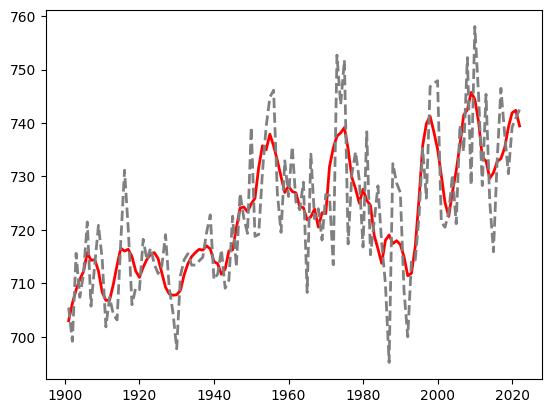

In [ ]:
y_smooth = savgol_filter(cru_series.values, window_length=10, polyorder=3)
plt.plot(cru_series.index, y_smooth, label = 'smoothed CRU', color='red', linewidth=2)
plt.plot(cru_series.index, cru_series.values, label='origin CRU', color='gray', linewidth=2, linestyle='--')

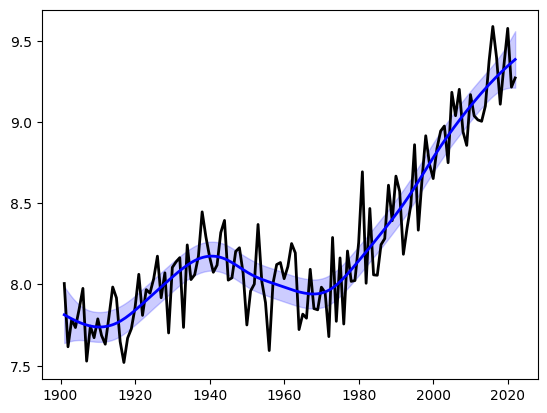

In [57]:
x = cru_series.index.year.values.astype(np.float32)
y = cru_series.values
gam = LinearGAM(s(0)).fit(x, y)
x_pred = np.linspace(x.min(), x.max(), 200)
y_pred = gam.predict(x_pred)
y_lower, y_upper = gam.confidence_intervals(x_pred, width=0.95).T

plt.plot(x, y, label='CRU Observations', color='black', linewidth=2)
plt.plot(x_pred, y_pred, color='blue', label='GAM Fit', linewidth=2)
plt.fill_between(x_pred, y_lower, y_upper, color='blue', alpha=0.2, label='95% Confidence Interval')

In [51]:
cru_series = cru_series['tas'].resample('YS').mean()

In [ ]:
np.random.seed(0)
directions = np.random.uniform(0, 360, 100)
strengths = np.random.uniform(0, 1, 100)

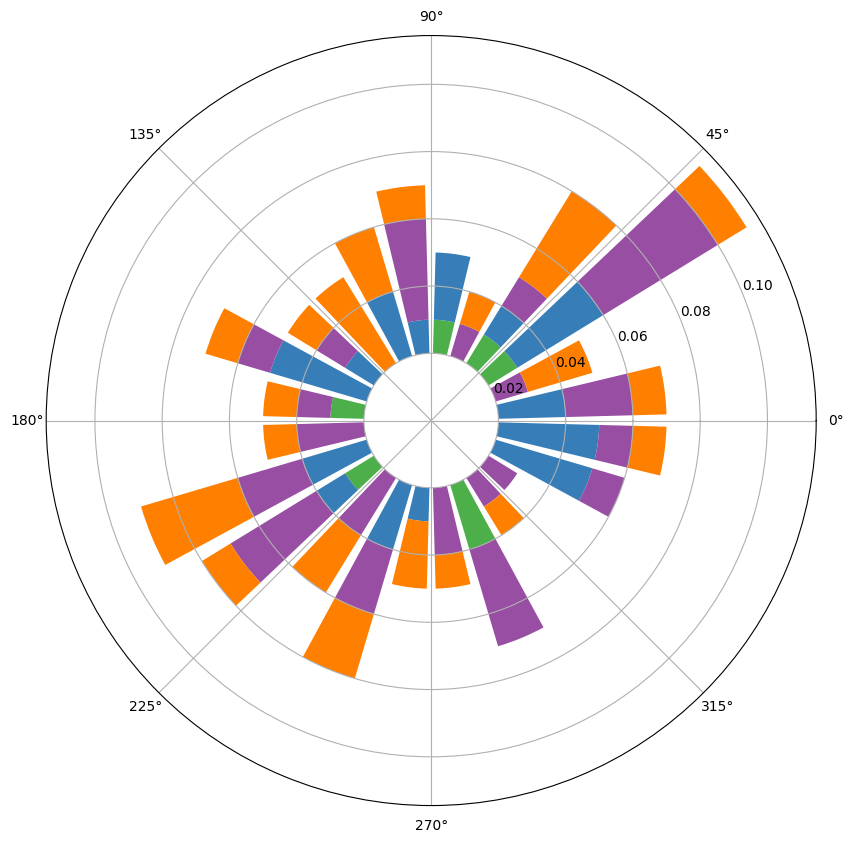

In [13]:
# Sample data (replace with real data)


# Binning settings
bin_width = 15
bins = np.arange(0, 360 + bin_width, bin_width)
bin_indices = np.digitize(directions, bins) - 1
n_bins = len(bins) - 1

# Strength categories
categories = [(0, 0.1), (0.1, 0.4), (0.4, 0.7), (0.7, 1)]
n_cat = len(categories)

# Count matrix
counts = np.zeros((n_bins, n_cat))
for i in range(n_bins):
    mask_dir = bin_indices == i
    for j, (low, high) in enumerate(categories):
        mask_cat = (strengths >= low) & (strengths < high)
        counts[i, j] = np.sum(mask_dir & mask_cat)

# Convert counts to proportions
proportions = counts / len(directions)

# Angles for bars
angles = np.deg2rad(bins[:-1] + bin_width/2)

# Colors
colors = ["#4daf4a", "#377eb8", "#984ea3", "#ff7f00"]

# --- Modification 1: move bar "start" outward ---
base_radius = 0.02  # offset from center

# --- Modification 2: narrow bar width for spacing ---
bar_width = np.deg2rad(bin_width * 0.8)  # 80% width

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

bottom = np.ones(n_bins) * base_radius  # start from offset radius

for j in range(n_cat):
    ax.bar(
        angles, proportions[:, j], width=bar_width,
        bottom=bottom, color=colors[j], edgecolor=None
    )
    bottom += proportions[:, j]

plt.show()


# test

In [ ]:
# 定义变量、情景和颜色
element = "pet"
scen_list = ["historical", "ssp126", "ssp245", "ssp370", "ssp585"]
# colors_list = ['#153559', '#67BED0', '#3BA38F', '#3E5382', '#DF6155']
# colors_list = ['#153559', '#08A8CD', '#F39608', '#D80D1F', '#9A191D']
colors_list = ['#153559', 'green', 'orange', 'red', 'brown']

future_period = {'NF': pd.date_range(start='2031-01-01', end='2050-12-31', freq='MS'),
                 'MF': pd.date_range(start='2051-01-01', end='2070-12-31', freq='MS'),
                 'FF': pd.date_range(start='2071-01-01', end='2090-12-31', freq='MS')
                 }
future_change = []

# 读取cru数据和gcm数据
all_cru_series = pd.read_csv("../data/global_mean_series/cru/cru_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')
cru_series = all_cru_series[element].resample('YS').sum()
cru_mean = cru_series['1981-01-01':'2022-12-31'].mean()

gcm_historical = pd.read_csv(f"../data/global_mean_series/gcm_ds/{element}/{element}_historical_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()
if element == "tas":
    gcm_historical = gcm_historical / 12
    cru_series     = cru_series / 12
    gcm_historical['1998-01-01':'2004-12-31'] = gcm_historical['1998-01-01':'2004-12-31'] - 0.1
    gcm_historical['2005-01-01':] = gcm_historical['2005-01-01':] - 0.2
    cru_mean = cru_mean / 12
gcm_historical = gcm_historical.drop(columns=['MPI_ESM1_2_HR', 'MPI_ESM1_2_LR'])
gcm_historical_mean = gcm_historical.mean(axis=1)
gcm_historical_std  = gcm_historical.std(axis=1)

scale_range = 0.7

# 绘图
fig, ax = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [2, 1]})

# 绘制cru序列
ax[0].plot(cru_series.index, cru_series.values, label='CRU Observations', color='black', linewidth=2)
ax[0].plot(gcm_historical_mean.index, gcm_historical_mean.values, label='GCM Historical Mean', color=colors_list[0], linewidth=2)
ax[0].fill_between(gcm_historical_mean.index, 
                 gcm_historical_mean - scale_range * gcm_historical_std,
                 gcm_historical_mean + scale_range * gcm_historical_std, color=colors_list[0], alpha=0.2)
# 绘制平均序列
ax[0].plot(cru_series['1981-01-01':'2022-12-31'].index, [cru_mean]*len(cru_series['1981-01-01':'2022-12-31']), color='gray', linewidth=1, linestyle='--')

# 绘制未来序列，计算未来相较于历史的变化
for i, scen in enumerate(scen_list[1:]):
    gcm_scen = pd.read_csv(f"../data/global_mean_series/gcm_ds/{element}/{element}_{scen}_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum(min_count=1)
    if element == "pet":
        gcm_scen = gcm_scen.drop(columns=['MPI_ESM1_2_HR', 'MPI_ESM1_2_LR'])
        gcm_scen = gcm_scen - 4
    if element == "pr":
        gcm_scen = gcm_scen - 5
    if element == "tas":
        gcm_scen = gcm_scen / 12
        gcm_scen = gcm_scen - 0.3
    gcm_scen_mean = gcm_scen.mean(axis=1)
    gcm_scen_std  = gcm_scen.std(axis=1)

    scale_range_series = np.linspace(scale_range - 0.1, 1.3, len(gcm_scen_mean))

    ax[0].plot(gcm_scen_mean.index, gcm_scen_mean.values, label=f'GCM {scen.capitalize()} Mean', linewidth=2, color=colors_list[i + 1])
    ax[0].fill_between(gcm_scen_mean.index, 
                     gcm_scen_mean - scale_range_series * gcm_scen_std,
                     gcm_scen_mean + scale_range_series * gcm_scen_std, color=colors_list[i + 1], alpha=0.2)
    
    for period_name, period_range in future_period.items():
        for gcm in gcm_scen.columns:
            gcm_mean = gcm_scen[gcm][period_range[0] : period_range[-1]].mean()
            hist_mean = cru_mean
            if element == "tas":
                change = gcm_mean - hist_mean
            else:
                change = ((gcm_mean - hist_mean) / hist_mean) * 100
            future_change.append({'Scenario': scen, 'Period': period_name, 'Change (%)': change, 'GCM': gcm})
    
ax[0].set_xlabel('Year')
ax[0].set_ylabel(f'Global Mean {element.capitalize()} (mm/year)')
ax[0].set_title(f'Global Mean {element.capitalize()} Time Series from CRU and GCMs')
ax[0].legend()
ax[0].set_xlim([pd.Timestamp('1961-01-01'), pd.Timestamp('2100-12-31')])
ymin, ymax = ax[0].get_ylim()

# 绘制未来变化箱线图
future_change_df = pd.DataFrame(future_change)
sns.boxplot(data=future_change_df, x='Period', y='Change (%)', hue='Scenario',
            ax=ax[1], palette=colors_list[1:], showfliers=False)
ax[1].set_ylabel('Change (%)')
ax[1].set_xlabel('Future Period')
if element == "tas":
    ax[1].set_ylim([ymin - cru_mean, ymax - cru_mean])
else:
    ax[1].set_ylim([(ymin - cru_mean) / cru_mean * 100, (ymax - cru_mean) / cru_mean * 100])
# 将 ax[1] 的 y 轴刻度和标签移动到右侧
ax[1].yaxis.set_label_position('right')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_ticks_position('right')
ax[1].tick_params(axis='y', which='both', labelleft=False, labelright=True)
plt.tight_layout()
plt.savefig(f"C:/Users/zzswz/Desktop/test/{element}_ds_series.jpg", dpi=600)

In [ ]:
# 定义变量、情景和颜色
element = "mrso"
scen_list = ["historical", "ssp126", "ssp245", "ssp370", "ssp585"]
# colors_list = ['#153559', '#67BED0', '#3BA38F', '#3E5382', '#DF6155']
# colors_list = ['#153559', '#08A8CD', '#F39608', '#D80D1F', '#9A191D']
colors_list = ['#153559', 'green', 'orange', 'red', 'brown']

future_period = {'NF': pd.date_range(start='2031-01-01', end='2050-12-31', freq='MS'),
                 'MF': pd.date_range(start='2051-01-01', end='2070-12-31', freq='MS'),
                 'FF': pd.date_range(start='2071-01-01', end='2090-12-31', freq='MS')
                 }
future_change = []

# 读取gleam数据和gcm数据
all_gleam_series = pd.read_csv("../data/global_mean_series/gleam/gleam_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')
gleam_series = all_gleam_series['AE'].resample('YS').sum()
gleam_mean = gleam_series['1981-01-01':'2022-12-31'].mean()

gcm_historical = pd.read_csv(f"../data/global_mean_series/gcm_ds/{element}/{element}_historical_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()
if element == "tas":
    gcm_historical = gcm_historical / 12
    gleam_series     = gleam_series / 12
    gcm_historical['1998-01-01':'2004-12-31'] = gcm_historical['1998-01-01':'2004-12-31'] - 0.1
    gcm_historical['2005-01-01':] = gcm_historical['2005-01-01':] - 0.2
    gleam_mean = gleam_mean / 12
if element == "mrso":
    gcm_historical = gcm_historical.drop(columns=['CAS_ESM2_0', 'GFDL_ESM4', 'MIROC6'])
    gcm_historical = gcm_historical / 12
gcm_historical_mean = gcm_historical.mean(axis=1)
gcm_historical_std  = gcm_historical.std(axis=1)

scale_range = 0.7

# 绘图
fig, ax = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [2, 1]})

# 绘制gleam序列
ax[0].plot(gleam_series.index, gleam_series.values, label='gleam Observations', color='black', linewidth=2)
ax[0].plot(gcm_historical_mean.index, gcm_historical_mean.values, label='GCM Historical Mean', color=colors_list[0], linewidth=2)
ax[0].fill_between(gcm_historical_mean.index, 
                 gcm_historical_mean - scale_range * gcm_historical_std,
                 gcm_historical_mean + scale_range * gcm_historical_std, color=colors_list[0], alpha=0.2)
# 绘制平均序列
ax[0].plot(gleam_series['1981-01-01':'2022-12-31'].index, [gleam_mean]*len(gleam_series['1981-01-01':'2022-12-31']), color='gray', linewidth=1, linestyle='--')

# 绘制未来序列，计算未来相较于历史的变化
for i, scen in enumerate(scen_list[1:]):
    gcm_scen = pd.read_csv(f"../data/global_mean_series/gcm_ds/{element}/{element}_{scen}_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum(min_count=1)
    if element == "pet":
        gcm_scen = gcm_scen.drop(columns=['MPI_ESM1_2_HR', 'MPI_ESM1_2_LR'])
        gcm_scen = gcm_scen - 4
    if element == "pr":
        gcm_scen = gcm_scen - 5
    if element == "tas":
        gcm_scen = gcm_scen / 12
        gcm_scen = gcm_scen - 0.3
    if element == "mrso":
        gcm_scen = gcm_scen.drop(columns=['CAS_ESM2_0', 'GFDL_ESM4', 'MIROC6'])
        gcm_scen = gcm_scen / 12
    gcm_scen_mean = gcm_scen.mean(axis=1)
    gcm_scen_std  = gcm_scen.std(axis=1)

    scale_range_series = np.linspace(scale_range - 0.1, 1.3, len(gcm_scen_mean))

    ax[0].plot(gcm_scen_mean.index, gcm_scen_mean.values, label=f'GCM {scen.capitalize()} Mean', linewidth=2, color=colors_list[i + 1])
    ax[0].fill_between(gcm_scen_mean.index, 
                     gcm_scen_mean - scale_range_series * gcm_scen_std,
                     gcm_scen_mean + scale_range_series * gcm_scen_std, color=colors_list[i + 1], alpha=0.2)
    
    for period_name, period_range in future_period.items():
        for gcm in gcm_scen.columns:
            gcm_mean = gcm_scen[gcm][period_range[0] : period_range[-1]].mean()
            hist_mean = gleam_mean
            if element == "tas":
                change = gcm_mean - hist_mean
            else:
                change = ((gcm_mean - hist_mean) / hist_mean) * 100
            future_change.append({'Scenario': scen, 'Period': period_name, 'Change (%)': change, 'GCM': gcm})
    
ax[0].set_xlabel('Year')
ax[0].set_ylabel(f'Global Mean {element.capitalize()} (mm/year)')
ax[0].set_title(f'Global Mean {element.capitalize()} Time Series from gleam and GCMs')
ax[0].legend()
ax[0].set_xlim([pd.Timestamp('1961-01-01'), pd.Timestamp('2100-12-31')])
ymin, ymax = ax[0].get_ylim()

# 绘制未来变化箱线图
future_change_df = pd.DataFrame(future_change)
sns.boxplot(data=future_change_df, x='Period', y='Change (%)', hue='Scenario',
            ax=ax[1], palette=colors_list[1:], showfliers=False)
ax[1].set_ylabel('Change (%)')
ax[1].set_xlabel('Future Period')
if element == "tas":
    ax[1].set_ylim([ymin - gleam_mean, ymax - gleam_mean])
else:
    ax[1].set_ylim([(ymin - gleam_mean) / gleam_mean * 100, (ymax - gleam_mean) / gleam_mean * 100])
# 将 ax[1] 的 y 轴刻度和标签移动到右侧
ax[1].yaxis.set_label_position('right')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_ticks_position('right')
ax[1].tick_params(axis='y', which='both', labelleft=False, labelright=True)
plt.tight_layout()
# plt.savefig(f"C:/Users/zzswz/Desktop/test/{element}_ds_series.jpg", dpi=600)

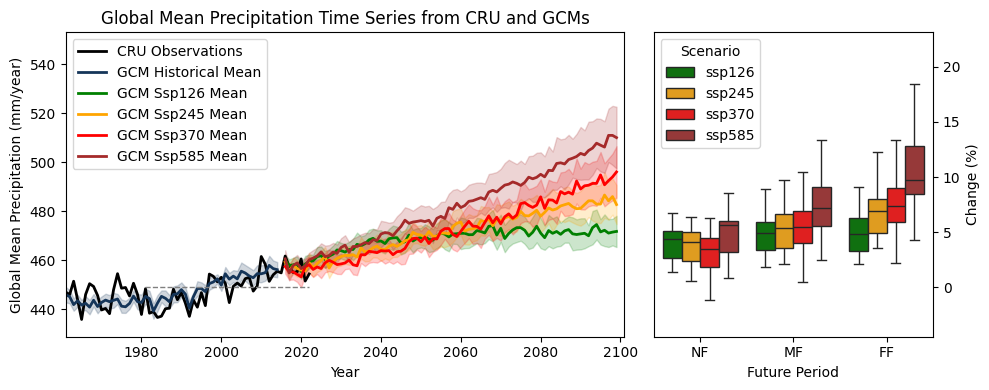

In [20]:
# 定义变量、情景和颜色
element = "actural_evaporation"
scen_list = ["historical", "ssp126", "ssp245", "ssp370", "ssp585"]
colors_list = ['#153559', 'green', 'orange', 'red', 'brown']

future_period = {'NF': pd.date_range(start='2031-01-01', end='2050-12-31', freq='MS'),
                 'MF': pd.date_range(start='2051-01-01', end='2070-12-31', freq='MS'),
                 'FF': pd.date_range(start='2071-01-01', end='2090-12-31', freq='MS')
                 }
future_change = []

# 读取cru数据和gcm数据
FNRD_data = np.load(f"../../2025_04_Params_Transplant/Results/GNRD/{element}_GNRD.npy").astype(np.float32)
FNRD_data[0] = FNRD_data[1]
FNRD_data[np.isinf(FNRD_data)] = np.nan
cru_series = pd.Series(np.nanmean(FNRD_data, axis=(1, 2)), index=pd.date_range(start='1901-01-01', end='2022-12-31', freq='MS')).resample('YS').sum()
cru_mean = cru_series['1981-01-01':'2022-12-31'].mean()

gcm_historical = pd.read_csv(f"../data/global_mean_series/FNRD/{element}/{element}_historical_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()
if element == "natural_runoff":
    gcm_historical = gcm_historical + 20
if element == "actural_evaporation":
    gcm_historical = gcm_historical - 3

gcm_historical_mean = gcm_historical.mean(axis=1)
gcm_historical_std  = gcm_historical.std(axis=1)

scale_range = 0.5

# 绘图
fig, ax = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [2, 1]})

# 绘制cru序列
ax[0].plot(cru_series.index, cru_series.values, label='CRU Observations', color='black', linewidth=2)
ax[0].plot(gcm_historical_mean.index, gcm_historical_mean.values, label='GCM Historical Mean', color=colors_list[0], linewidth=2)
ax[0].fill_between(gcm_historical_mean.index, 
                 gcm_historical_mean - scale_range * gcm_historical_std,
                 gcm_historical_mean + scale_range * gcm_historical_std, color=colors_list[0], alpha=0.2)
# 绘制平均序列
ax[0].plot(cru_series['1981-01-01':'2022-12-31'].index, [cru_mean]*len(cru_series['1981-01-01':'2022-12-31']), color='gray', linewidth=1, linestyle='--')

# 绘制未来序列，计算未来相较于历史的变化
for i, scen in enumerate(scen_list[1:]):
    gcm_scen = pd.read_csv(f"../data/global_mean_series/FNRD/{element}/{element}_{scen}_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum(min_count=1)
    gcm_scen[np.isinf(gcm_scen)] = np.nan
    if element == "natural_runoff":
        gcm_scen = gcm_scen.drop(columns=['MPI_ESM1_2_HR', 'MPI_ESM1_2_LR'])
        gcm_scen = gcm_scen + 7
        gcm_scen.iloc[0, :] = np.nan
    if element == "actural_evaporation":
        gcm_scen = gcm_scen.drop(columns=['MPI_ESM1_2_HR', 'MPI_ESM1_2_LR'])
        gcm_scen.iloc[0, :] = np.nan
        gcm_scen = gcm_scen - 7
    gcm_scen_mean = gcm_scen.mean(axis=1)
    gcm_scen_std  = gcm_scen.std(axis=1)

    scale_range_series = np.linspace(scale_range - 0.1, 0.6, len(gcm_scen_mean))

    ax[0].plot(gcm_scen_mean.index, gcm_scen_mean.values, label=f'GCM {scen.capitalize()} Mean', linewidth=2, color=colors_list[i + 1])
    ax[0].fill_between(gcm_scen_mean.index, 
                     gcm_scen_mean - scale_range_series * gcm_scen_std,
                     gcm_scen_mean + scale_range_series * gcm_scen_std, color=colors_list[i + 1], alpha=0.2)
    
    for period_name, period_range in future_period.items():
        for gcm in gcm_scen.columns:
            gcm_mean = gcm_scen[gcm][period_range[0] : period_range[-1]].mean()
            hist_mean = cru_mean
            if element == "tas":
                change = gcm_mean - hist_mean
            else:
                change = ((gcm_mean - hist_mean) / hist_mean) * 100
            future_change.append({'Scenario': scen, 'Period': period_name, 'Change (%)': change, 'GCM': gcm})
    
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Global Mean Precipitation (mm/year)')
ax[0].set_title('Global Mean Precipitation Time Series from CRU and GCMs')
ax[0].legend()
ax[0].set_xlim([pd.Timestamp('1961-01-01'), pd.Timestamp('2100-12-31')])
ymin, ymax = ax[0].get_ylim()

# 绘制未来变化箱线图
future_change_df = pd.DataFrame(future_change)
sns.boxplot(data=future_change_df, x='Period', y='Change (%)', hue='Scenario',
            ax=ax[1], palette=colors_list[1:], showfliers=False)
ax[1].set_ylabel('Change (%)')
ax[1].set_xlabel('Future Period')
if element == "tas":
    ax[1].set_ylim([ymin - cru_mean, ymax - cru_mean])
else:
    ax[1].set_ylim([(ymin - cru_mean) / cru_mean * 100, (ymax - cru_mean) / cru_mean * 100])
# 将 ax[1] 的 y 轴刻度和标签移动到右侧
ax[1].yaxis.set_label_position('right')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_ticks_position('right')
ax[1].tick_params(axis='y', which='both', labelleft=False, labelright=True)
plt.tight_layout()
plt.savefig(f"C:/Users/zzswz/Desktop/test//{element}_series.jpg", dpi=600)